<a href="https://colab.research.google.com/github/SergeiVKalinin/Research-Projects/blob/main/DKL_hAE/Forensic_Toy_Data_Seeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable ML and Human in the Loop interventions for the Automated Experiment: Deep Kernel Learning for Toy Data with Seeding

- Initial workflow build by Yongtao Liu, https://scholar.google.com/citations?hl=en&user=V9FMPgQAAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?hl=en&user=YnSdOoUAAAAJ  


# **1. Import and download data**

In [ ]:
#@title
%%capture
!pip install -q git+https://github.com/pycroscopy/atomai.git
# !pip install atomai
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install lmfit

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import gpax
import numpyro
import jax
import jax.numpy as jnp
import math
import atomai as aoi
import torch
import os
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from lmfit.models import GaussianModel

from atomai import utils
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

## Load helper functions

In [ ]:
#@title help fucntions
# Load helper functions
from typing import Tuple

def make_window(imgsrc: np.ndarray, window_size: int,
                xpos: int, ypos: int) -> np.ndarray:
    """
    Returns the portion of the image within the window given the
    image (imgsrc), the x position and the y position
    """
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc

def create_training_set(imgdata: np.ndarray, target: np.ndarray,
                        window_size: int) -> Tuple[np.ndarray]:
    """
    Creates arrays with features (local subimages)
    and targets (corresponding spectra) from hyperspectral data
    """
    feature_arr, target_arr = [], []
    pos = []
    s1, s2 = imgdata.shape[:-1]
    for i in range(s1):
        for j in range(s2):
            arr_loc = make_window(imgdata, window_size, i, j)
            if arr_loc.shape[:-1] != (window_size, window_size):
                continue
            feature_arr.append(arr_loc)
            target_arr.append(target[i, j])
            pos.append([i, j])
    return np.array(pos), np.array(feature_arr), np.array(target_arr)

from typing import Tuple, Optional, Dict, Union, List

def get_imgstack(imgdata: np.ndarray,
                 coord: np.ndarray,
                 r: int) -> Tuple[np.ndarray]:
    """
    Extracts subimages centered at specified coordinates
    for a single image
    Args:
        imgdata (3D numpy array):
            Prediction of a neural network with dimensions
            :math:`height \\times width \\times n channels`
        coord (N x 2 numpy array):
            (x, y) coordinates
        r (int):
            Window size
    Returns:
        2-element tuple containing
        - Stack of subimages
        - (x, y) coordinates of their centers
    """
    img_cr_all = []
    com = []
    for c in coord:
        cx = int(np.around(c[0]))
        cy = int(np.around(c[1]))
        if r % 2 != 0:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2+1,
                        cy-r//2:cy+r//2+1])
        else:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2,
                        cy-r//2:cy+r//2])
        if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
            img_cr_all.append(img_cr[None, ...])
            com.append(c[None, ...])
    if len(img_cr_all) == 0:
        return None, None
    img_cr_all = np.concatenate(img_cr_all, axis=0)
    com = np.concatenate(com, axis=0)
    return img_cr_all, com


def extract_subimages(imgdata: np.ndarray,
                      coordinates: Union[Dict[int, np.ndarray], np.ndarray],
                      window_size: int, coord_class: int = 0) -> Tuple[np.ndarray]:

    if isinstance(coordinates, np.ndarray):
        coordinates = np.concatenate((
            coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1)
        coordinates = {0: coordinates}
    if np.ndim(imgdata) == 2:
        imgdata = imgdata[None, ..., None]
    subimages_all, com_all, frames_all = [], [], []
    for i, (img, coord) in enumerate(
            zip(imgdata, coordinates.values())):
        coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
        stack_i, com_i = get_imgstack(img, coord_i, window_size)
        if stack_i is None:
            continue
        subimages_all.append(stack_i)
        com_all.append(com_i)
        frames_all.append(np.ones(len(com_i), int) * i)
    if len(subimages_all) > 0:
        subimages_all = np.concatenate(subimages_all, axis=0)
        com_all = np.concatenate(com_all, axis=0)
        frames_all = np.concatenate(frames_all, axis=0)

    return subimages_all, com_all, frames_all

def extract_patches_and_spectra(hdata: np.ndarray, *args: np.ndarray,
                                coordinates: np.ndarray = None,
                                window_size: int = None,
                                avg_pool: int = 2,
                                **kwargs: Union[int, List[int]]
                                ) -> Tuple[np.ndarray]:
    """
    Extracts image patches and associated spectra
    (corresponding to patch centers) from hyperspectral dataset
    Args:
        hdata:
            3D or 4D hyperspectral data
        *args:
            2D image for patch extraction. If not provided, then
            patches will be extracted from hyperspectral data
            averaged over a specified band (range of "slices")
        coordinates:
            2D numpy array with xy coordinates
        window_size:
            Image patch size
        avg_pool:
            Kernel size and stride for average pooling in spectral dimension(s)
        **band:
            Range of slices in hyperspectral data to average over
            for producing a 2D image if the latter is not provided as a separate
            argument. For 3D data, it can be integer (use a single slice)
            or a 2-element list. For 4D data, it can be integer or a 4-element list.
        Returns:
            3-element tuple with image patches, associated spectra and coordinates
    """
    F = torch.nn.functional
    if hdata.ndim not in (3, 4):
        raise ValueError("Hyperspectral data must 3D or 4D")
    if len(args) > 0:
        img = args[0]
        if img.ndim != 2:
            raise ValueError("Image data must be 2D")
    else:
        band = kwargs.get("band", 0)
        if hdata.ndim == 3:
            if isinstance(band, int):
                band = [band, band+1]
            img = hdata[..., band[0]:band[1]].mean(-1)
        else:
            if isinstance(band, int):
                band = [band, band+1, band, band+1]
            elif isinstance(band, list) and len(band) == 2:
                band = [*band, *band]
            img = hdata[..., band[0]:band[1], band[2]:band[3]].mean((-2, -1))
    patches, coords, _ = extract_subimages(img, coordinates, window_size)
    patches = patches.squeeze()
    spectra = []
    for c in coords:
        spectra.append(hdata[int(c[0]), int(c[1])])
    avg_pool = 2*[avg_pool] if (isinstance(avg_pool, int) & hdata.ndim == 4) else avg_pool
    torch_pool = F.avg_pool1d if hdata.ndim == 3 else F.avg_pool2d
    spectra = torch.tensor(spectra).cpu().unsqueeze(1)
    spectra = torch_pool(spectra, avg_pool, avg_pool).squeeze().numpy()
    return patches, spectra, coords

In [ ]:
#@title # DKL specific functions

def plot_dkl(full_img, window_size, y,
             dkl_mean, dkl_var):

    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(1,3,width_ratios = [1,1,1])
    ax00,ax01,ax02 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2])

    s1, s2 = full_img.shape[0] - window_size+1, full_img.shape[1] - window_size+1

    if y.ndim == 1:   # Scalar DKL
        original    = y.reshape(s1,s2)
        predicted   = dkl_mean.reshape(s1,s2)
        uncertainty = dkl_var.reshape(s1,s2)

    elif y.ndim == 2: # Vector DKL
        original    = np.swapaxes(y.reshape(-1,s1,s2).T, 0, 1)
        predicted   = np.swapaxes(dkl_mean.reshape(-1,s1,s2).T, 0, 1)
        uncertainty = np.swapaxes(dkl_var.reshape(-1,s1,s2).T, 0, 1)

    ax00.imshow(original)
    ax01.imshow(predicted)
    ax02.imshow(uncertainty)

    ax00.set_title("original")
    ax01.set_title("mean (prediction)")
    ax02.set_title("variance (uncertainty)")

    if y.ndim == 2: # we can show individual spectra. Otherwise, we've already scalarized it

        rng = np.random.default_rng()
        xx_ = rng.choice(s1, 3, replace = False)
        yy_ = rng.choice(s2, 3, replace = False)
        XY = np.asarray([xx_,yy_]).T

        x1,y1 = XY[0]
        x2,y2 = XY[1]
        x3,y3 = XY[2]

        ax00.scatter(x1,y1, c='dodgerblue', ec='k', s=100)
        ax00.scatter(x2,y2, c='darkorange', ec='k', s=100)
        ax00.scatter(x3,y3, c='crimson', ec='k', s=100)

        plt.figure(figsize=(10,5))
        ax = plt.gca()

        ax.plot(original[y1,x1], c='dodgerblue', lw = 2, ls ='--')
        ax.plot(original[y2,x2], c='darkorange', lw = 2, ls ='--')
        ax.plot(original[y3,x3], c='crimson', lw = 2, ls ='--')

        ax.plot(predicted[y1,x1], c='dodgerblue', lw = 2)
        ax.plot(predicted[y2,x2], c='darkorange', lw = 2)
        ax.plot(predicted[y3,x3], c='crimson', lw = 2)

        ax.axhline(0, c='k')
        ax.set_xlabel("Energy loss (eV)", fontsize = 22)
        ax.tick_params(length=5, width=3, labelsize = 18)


#@title Function for plotting DKL prediction and uncertainty
def plot_dkl_result (ground_truth, dkl_mean,
                     dkl_var, indices=None, ws=None,
                     scatter_location = False):
  '''
  Function plots DKL prediction and uncertainty.
  Setting scatter_location = True and providing indices_train
  and window_size enable plotting training data points in ground
  truth.
  '''

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))

  cm = 'viridis'
  shrink = 0.7
  pix = int(math.sqrt(len(dkl_mean)))

  im1 = ax1.imshow(ground_truth.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
  fig.colorbar(im1, ax=ax1, shrink = shrink)
  if scatter_location == True:
    ax1.scatter(indices[:, 1]-int(ws/2), indices[:, 0]-int(ws/2), s=12,
                c = np.arange(len(indices)), cmap = 'bwr')
  ax1.set_title("Ground Truth")
  ax1.axis('off')

  im2 = ax2.imshow(dkl_mean.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
  fig.colorbar(im2, ax=ax2, shrink = shrink)
  ax2.set_title("DKL Prediction")
  ax2.axis('off')

  im3 = ax3.imshow(dkl_var.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
  fig.colorbar(im3, ax=ax3, shrink = shrink)
  ax3.set_title("DKL Uncertainty")
  ax3.axis('off')

  plt.show()
  plt.close(fig)


from typing import Union

def EI(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
       best_f: Union[float, torch.Tensor], xi: float = 0.01) -> np.ndarray:
    """
    Expected Improvement
    """
    device=model.device
    dtype = model.dtype
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    best_f = torch.from_numpy(best_f) if isinstance(best_f, float) else best_f
    posterior = model._compute_posterior(X.to(dtype).to(device))
    samples = posterior.rsample(torch.Size([1000, ]))
    mean, sigma = samples.mean(0), samples.var(0).sqrt()
    u = (mean - best_f.expand_as(mean) - xi) / sigma
    normal = torch.distributions.Normal(torch.zeros_like(u), torch.ones_like(u))
    ucdf = normal.cdf(u)
    updf = torch.exp(normal.log_prob(u))
    obj = sigma * (updf + u * ucdf)
    return obj.detach().cpu().numpy()


def qEI(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
        best_f: Union[float, torch.Tensor], xi: float = 0.01,
        **kwargs: int) -> np.ndarray:
    """
    MC-based Expected Improvement
    """
    device = model.device
    dtype = model.dtype
    sampler = botorch.sampling.SobolQMCNormalSampler(500, kwargs.get("seed", 42))
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    best_f = torch.from_numpy(best_f) if isinstance(best_f, float) else best_f
    posterior = model.gp_model.posterior(X.to(dtype).to(device))
    samples = sampler(posterior)
    objective = botorch.acquisition.IdentityMCObjective()
    obj = objective(samples)
    obj = (obj - best_f.unsqueeze(-1).to(obj) - xi).clamp_min(0).detach().cpu()
    return obj.numpy()

def UCB(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
        beta: float = 0.2) -> np.ndarray:
    """
    Upper confidence bound
    """
    device = model.device
    dtype = model.dtype
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    beta = torch.tensor(beta) if isinstance(beta, float) else beta
    posterior = model._compute_posterior(X.to(dtype).to(device))
    samples = posterior.rsample(torch.Size([1000, ]))
    mean, var = samples.mean(0), samples.var(0)
    delta = (beta.expand_as(mean).to(dtype).to(device) * var).sqrt()
    return (mean + delta).detach().cpu().numpy()

def qUCB(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
         beta: float = 0.2, **kwargs: int) -> np.ndarray:
    """
    MC-based upper confidence bound
    """
    device = model.device
    dtype = model.dtype
    X = torch.from_numpy(X) if isinstance(X, np.ndarray) else X
    beta_prime = math.sqrt(beta * math.pi / 2)
    posterior = model.gp_model.posterior(X.to(dtype).to(device))
    sampler = botorch.sampling.SobolQMCNormalSampler(500, kwargs.get("seed", 42))
    samples = sampler(posterior)
    objective = botorch.acquisition.IdentityMCObjective()
    obj = objective(samples)
    mean = obj.mean(dim=0)
    obj = mean + beta_prime * (obj - mean).abs()
    return obj.detach().cpu().numpy()


# Functions for plotting result, selecting next measurement point, and update train/test dataset
def sel_next_point (dklgp, X_train, X_test, xi):
  '''
  Function selects next_point_idx based on either EI
  acquision function (0) or maximum uncertainty point (1)
  '''
  global acq_idx
  if acq_idx == 0:  # 0 uses EI function
    best_f = torch.tensor(dklgp.predict(X_train)[0].max(), device=dklgp.device)
    obj = EI(dklgp, X_test, best_f, xi)
    next_point_idx = obj.mean(0).argmax()
  elif acq_idx == 1:  # 1 explores the max uncertainty point
    mean0, var0 = dklgp.predict(X_test, batch_size=len(X_test))
    next_point_idx = var0.argmax()
  elif acq_idx == 2:  # 2 uses UCB function
    obj = UCB(dklgp, X_test)
    next_point_idx = obj.mean(0).argmax()

  return next_point_idx

def update_train_test_data(X_train, X_test, y_train, y_test,
                           indices_train, indices_test,
                           next_point_idx, measured_point, next_point):
  X_train = np.append(X_train, X_test[next_point_idx][None], 0)
  X_test = np.delete(X_test, next_point_idx, 0)
  y_train = np.append(y_train, measured_point)
  y_test = np.delete(y_test, next_point_idx)
  indices_train = np.append(indices_train, next_point[None], 0)
  indices_test = np.delete(indices_test, next_point_idx, 0)

  return (X_train, X_test, y_train, y_test, indices_train, indices_test)



# Define a function to run DKL exploration
def dkl_explore (save_explore, num_cycles = 200):
  global X, y, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws
  # Here X_train and y_train are our measured image patches and spectra information,
  # whereas X_test and y_test are the "unknown" ones. The indices_train are grid coordinates of the measured points,
  # whereas the indices_test are the grid coordinates of the remaining available points on the grid
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)
  print('X_train shape: '); print(X_train.shape)
  data_dim = X_train.shape[-1]

  if not os.path.exists(rf + acq_funcs[acq_idx] + save_explore):
    os.mkdir(rf + acq_funcs[acq_idx] + save_explore)
  os.chdir(rf + acq_funcs[acq_idx] + save_explore)
  np.savez("initial_traindata.npz", X_train = X_train, X_test = X_test, y_train = y_train,
           y_test = y_test, indices_train = indices_train, indices_test = indices_test)

  for e in range(exploration_steps):
    clear_output()
    print("{}/{}".format(e+1, exploration_steps))
    # Update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles)

    mean, var = dklgp.predict(X, batch_size=len(X))
    # plot_dkl_result(y, mean, var, indices=indices_train,
    #                 ws = ws, scatter_location = True)

    plot_dkl_result(y, mean, var)
    # Compute acquisition function
    next_point_idx = sel_next_point (dklgp, X_train, X_test, xi)
    next_point = indices_test[next_point_idx]

    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point)

    # Save result
    np.savez("record{}.npz".format(e),
             mean = mean, var = var, next_point_idx = next_point_idx,
             next_point = next_point, measured_point = measured_point)
  # Save final traindata
  np.savez("final_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)





def dkl_counterfactual(y, save_counter, num_cycles = 200):
  global X, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws
  # Initialize train/test datasets
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)

  # Set path for saving result
  if not os.path.exists(rf + acq_funcs[acq_idx] + save_counter):
    os.mkdir(rf + acq_funcs[acq_idx] + save_counter)

  # Save initial train data
  os.chdir(rf + acq_funcs[acq_idx] + save_counter)
  np.savez("initial_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)

  # Start DKL analysis
  for e in range(exploration_steps):
    clear_output()
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles, lr = 0.01)

    mean, var = dklgp.predict(X, batch_size=len(X))
    # plot_dkl_result(y, mean, var, indices=indices_train,
    #                 ws = ws, scatter_location = True)
    plot_dkl_result(y, mean, var)

    #########################################################
    #################### Critical step ######################
    #########################################################

    # Load measurement locations from Step 1
    os.chdir(rf + acq_funcs[acq_idx] + save_explore)
    rec = np.load("record{}.npz".format(e))
    next_point_idx = rec['next_point_idx']
    next_point = indices_test[next_point_idx]
    #########################################################
    #########################################################

    # Do "measurement"
    measured_point = y_test[next_point_idx]

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point)

    # Save result
    os.chdir(rf + acq_funcs[acq_idx] + save_counter)
    np.savez("record{}.npz".format(e),
             mean = mean, var = var, next_point_idx = next_point_idx,
             next_point = next_point, measured_point = measured_point)

  # Save final traindata
  os.chdir(rf + acq_funcs[acq_idx] + save_counter)
  np.savez("final_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)


# Define a function to run dkl analysis with random sampling
def dkl_random(y, save_random, num_cycles = 200):
  global X, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws
  # Initialize train/test datasets
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)

  # Set path for saving result
  if not os.path.exists(rf + acq_funcs[acq_idx] + save_random):
    os.mkdir(rf + acq_funcs[acq_idx] + save_random)

  # Save initial train data
  os.chdir(rf + acq_funcs[acq_idx] + save_random)
  np.savez("initial_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)

  # Start DKL analysis
  for e in range(exploration_steps):
    clear_output()
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles, lr = 0.01)

    mean, var = dklgp.predict(X, batch_size=len(X))
    # plot_dkl_result(y, mean, var, indices=indices_train,
    #                 ws = ws, scatter_location = True)
    plot_dkl_result(y, mean, var)

    #########################################################
    #################### Critical step ######################
    #########################################################
    next_point_idx = np.random.randint(len(X_test))
    next_point = indices_test[next_point_idx]
    #########################################################
    #########################################################

    # Do "measurement"
    measured_point = y_test[next_point_idx]

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point)

    # Save result
    os.chdir(rf + acq_funcs[acq_idx] + save_random)
    np.savez("record{}.npz".format(e),
             mean = mean, var = var, next_point_idx = next_point_idx,
             next_point = next_point, measured_point = measured_point)

  # Save final traindata
  os.chdir(rf + acq_funcs[acq_idx] + save_random)
  np.savez("final_traindata.npz", X_train = X_train, X_test = X_test,
           y_train = y_train, y_test = y_test,
           indices_train = indices_train, indices_test = indices_test)




# Define a function to run dkl counterfactual with different scalarizer
def dkl_mature_full(y, save_mature_full, num_cycles = 200):
  global X, indices_all, ts, rs, rf, acq_funcs, exploration_steps, acq_idx, ws

  # Load last step train dataset
  os.chdir(rf + acq_funcs[acq_idx] + save_explore)
  rec = np.load("final_traindata.npz")
  X_train = rec["X_train"]
  y_train = rec["y_train"]

  # Train a matured DKL model with the last step train dataset
  # dklgp0 will be the matured DKL model
  dklgp0 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
  dklgp0.fit(X_train, y_train, training_cycles=num_cycles)

  # Train a full-informed DKL model with all data
  # dklgp1 will be the full-informed DKL model
  dklgp1 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
  dklgp1.fit(X, y, training_cycles=num_cycles)

  # Initialize train/test datasets
  (X_train, X_test, y_train, y_test,
   indices_train, indices_test) = train_test_split(
       X, y, indices_all, test_size=ts, shuffle=True, random_state=rs)

  # Set path for saving result
  if not os.path.exists(rf + acq_funcs[acq_idx] + save_mature_full):
    os.mkdir(rf + acq_funcs[acq_idx] + save_mature_full)

  # Start DKL analysis
  for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    #update GP posterior
    dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp.fit(X_train, y_train, training_cycles=num_cycles, lr = 0.01)

    mean, var = dklgp.predict(X_test, batch_size=len(X_test))  #real-time DKL model
    mean0, var0 = dklgp0.predict(X_test, batch_size=len(X_test)) #matured DKL model
    mean1, var1 = dklgp1.predict(X_test, batch_size=len(X_test)) #full-informed DKL model

    # Load measurement location from Step 1
    os.chdir(rf + acq_funcs[acq_idx] + save_explore)
    rec = np.load("record{}.npz".format(e))
    next_point_idx = rec['next_point_idx']
    next_point = indices_test[next_point_idx]

    # Do "measurement"
    measured_point = y_test[next_point_idx]

        # Save result
    os.chdir(rf + acq_funcs[acq_idx] + save_mature_full)
    np.savez("record{}.npz".format(e), y_test = y_test,
             mean = mean, var = var,
             mean0 = mean0, var0 = var0,
             mean1 = mean1, var1 = var1)

    # Update train and test datasets
    (X_train, X_test, y_train, y_test, indices_train,
     indices_test) = update_train_test_data(X_train, X_test, y_train, y_test,
                                            indices_train, indices_test,
                                            next_point_idx, measured_point, next_point = next_point)


## Generate Toy Data

In [ ]:
def gs_spectrum(x, amplitude, center, wid):
    return (amplitude/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-center)**2 /(2*wid**2))

def img_simulator(img_size, A = 1, offsetx = 20, offsety=5, fre=2.5, distri = 5):
  im_x, im_y = np.ogrid[:img_size, :img_size]
  # Creating a rotation-invariant image with different spatial frequencies.
  image_rot = A*(np.exp(.9j * np.hypot(im_x-offsetx, im_y-offsety) / fre ).real + distri)
  return image_rot

def spec_simulator(patch):
  size = 20
  patch1D = patch.reshape(-1)
  x = np.arange(len(patch1D))/10
  amplitude = patch1D.mean()
  offset = np.where(patch==patch.max())
  offset = np.sqrt((offset[0][0])**2 + (offset[1][0])**2) + 5 + np.random.randint(low = 0, high = 5)
  std = np.std(patch1D)
  spec = gs_spectrum(x, amplitude=amplitude, center=offset, wid=std*np.random.randint(low=10, high=20))
  noise = np.random.normal(loc=0, scale=0.002*np.random.randint(10), size=len(patch1D))
  return x, spec + noise

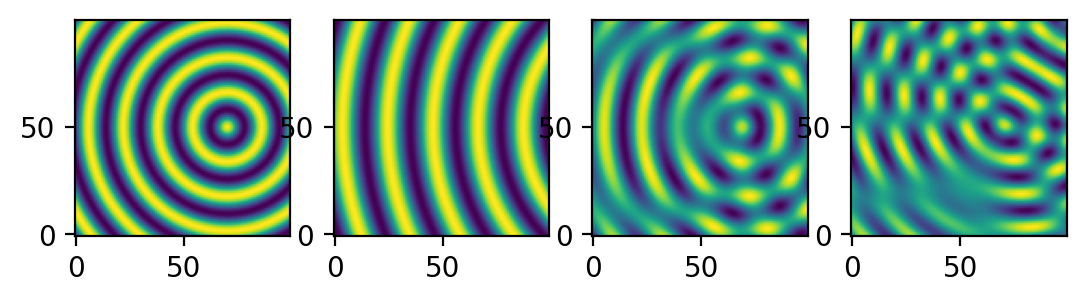

In [ ]:
#simulate an image
img_size_ = 100
img1 = img_simulator(img_size_, A=7, offsetx = 50, offsety=70, fre=2.3, distri = 15)
img2 = img_simulator(img_size_, A=5, offsetx = 50, offsety=150, fre=3, distri = 5)
img3 = img_simulator(img_size_, A=5, offsetx = 100, offsety=100, fre=2, distri = 10)
img4 = img_simulator(img_size_, A=4, offsetx = 50, offsety=50, fre=5, distri = 5)

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, dpi = 200)
ax1.imshow(img1, origin = "lower")
ax2.imshow(img2, origin = "lower")
ax3.imshow(img1 + img2, origin = "lower")
ax4.imshow(img1 + img3, origin = "lower")

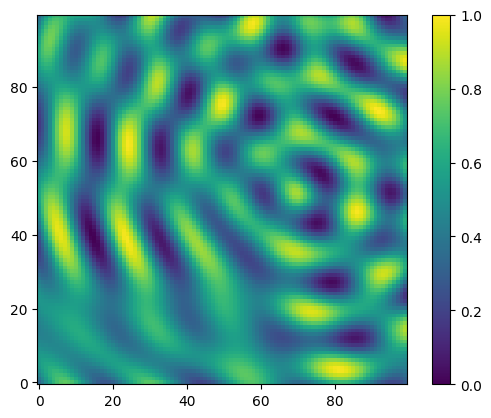

In [ ]:
full_img = img1 + img2 +img3 + np.random.rand(img_size_, img_size_)/10
full_img = ((full_img-full_img.min())/full_img.ptp())
plt.imshow(full_img, origin = "lower")
plt.colorbar()

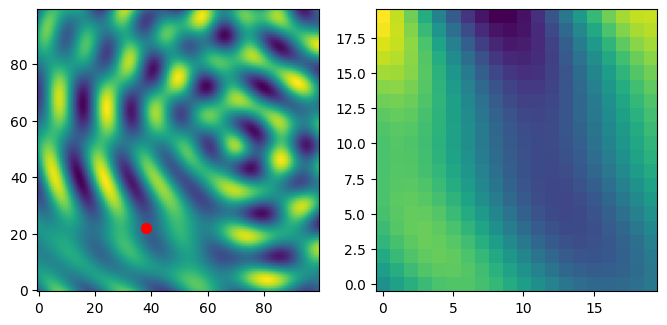

In [ ]:
#normalize
norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
patch_image = norm_(full_img) #normalize amplitude

# extract subimage for each point on a grid
coordinates = utils.get_coord_grid(patch_image, 1)   #grid

ws = 20  #patch window size
pix = int(len(patch_image)+1-ws)  #total pixel number

features_all, indices_all, _ = utils.extract_subimages(patch_image, coordinates, ws)
features_all = features_all[:,:,:,0]

# Show example patch and whole image
k = 1000  # index
_, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(patch_image, origin = 'lower')
ax1.scatter(indices_all[k, 1], indices_all[k, 0], c = 'r', s = 50)
ax2.imshow(features_all[k], origin = 'lower')

In [ ]:
# Simulate spectra for features
spec_all = np.zeros((features_all.shape[0], features_all.shape[1]*features_all.shape[2]))
for i in range (features_all.shape[0]):
  x, y = spec_simulator(features_all[i])
  spec_all[i] = y

x0 = x

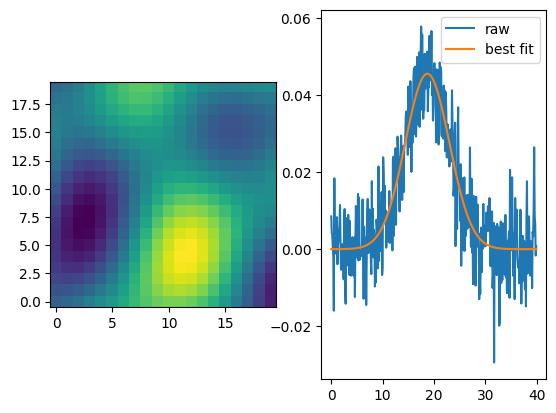

Amplitude: 0.4914404766718358, Center: 18.701513007073434, Sigma: 4.298262014424357


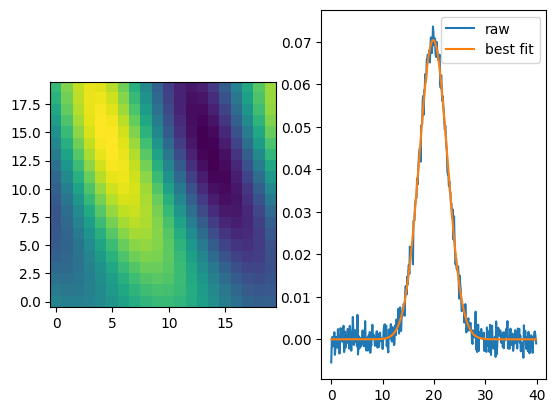

Amplitude: 0.4845527389753331, Center: 19.859158407903216, Sigma: 2.745174775887883


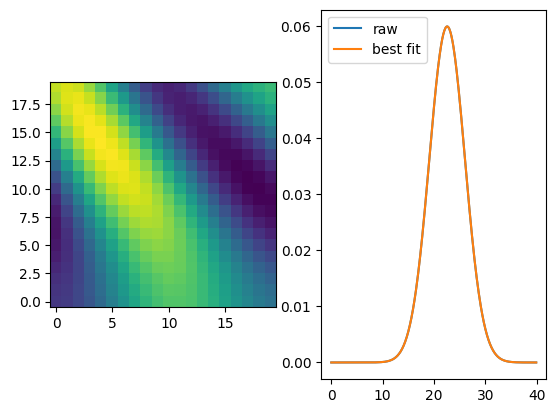

Amplitude: 0.5201946609592428, Center: 22.560219778561034, Sigma: 3.463097168208697


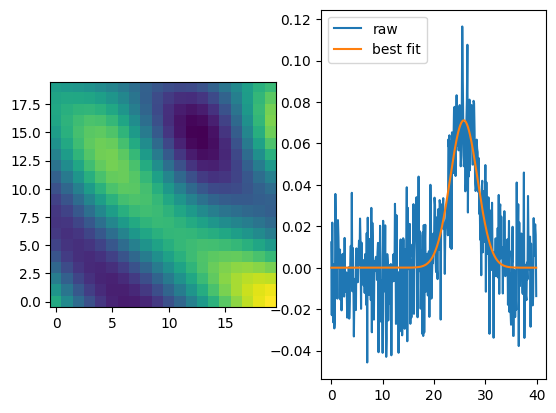

Amplitude: 0.4735701338231667, Center: 25.798607612907038, Sigma: 2.656519925228776


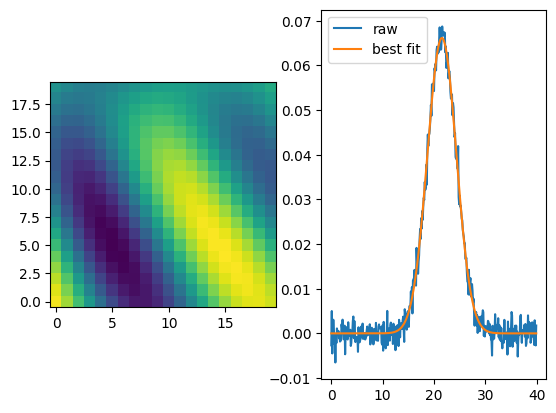

Amplitude: 0.4678672312624358, Center: 21.53503938774278, Sigma: 2.8214857534522357


In [ ]:
for i in range(5):
  idx = np.random.randint(features_all.shape[0])
  y = spec_all[idx]
  #fit
  mod = GaussianModel()
  pars = mod.guess(y, x=x0)
  out = mod.fit(y, pars, x=x0)
  #plot
  _, (ax1, ax2) = plt.subplots(1, 2, dpi = 100)
  ax1.imshow(features_all[idx], origin = "lower")
  ax2.plot(x0, y, label = 'raw')
  ax2.plot(x0, out.best_fit, '-', label='best fit')
  ax2.legend()
  plt.show()

  report = out.best_values
  print("Amplitude: {}, Center: {}, Sigma: {}".format(report['amplitude'],
                                                      report['center'],
                                                      report['sigma'] ))

In [ ]:
target_amp = np.zeros(features_all.shape[0])
target_cen = np.zeros(features_all.shape[0])
target_sig = np.zeros(features_all.shape[0])

for i in range (features_all.shape[0]):
  # raw spectrum
  y = spec_all[i]
  # fit
  mod = GaussianModel()
  pars = mod.guess(y, x=x0)
  out = mod.fit(y, pars, x=x0)

  # fit results
  report = out.best_values
  target_amp[i] = report['amplitude']
  target_cen[i] = report['center']
  target_sig[i] = report['sigma']

tar_amp = norm_(target_amp)
tar_cen = norm_(target_cen)
tar_sig = norm_(target_sig)

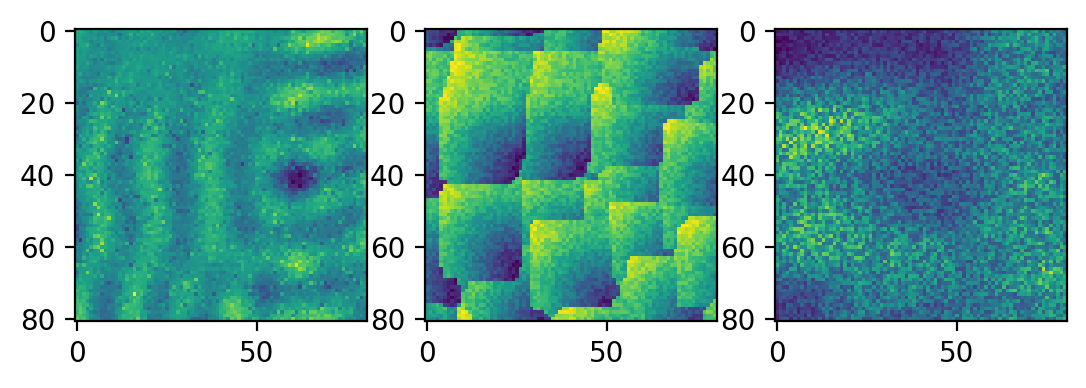

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi = 200)
ax1.imshow(tar_amp.reshape(pix, pix))
ax2.imshow(tar_cen.reshape(pix, pix))
ax3.imshow(tar_sig.reshape(pix, pix))

Prepare train dataset

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)  #training input: image patches

y_targ = tar_amp     #training output
y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())

y = y_targ.reshape(-1)
X.shape, y.shape

((6561, 400), (6561,))

# **3. DKL on full data (complete model)**

As a first step, let's initialize and train DKL-GPR model on the **<font color = 'dodgerblue'>FULL</font>** dataset. This is impossible for AE, but it creates a **complete** model - trained on all the data that can be obtained from this region. We can use this full model to check how fast the **live** (real time) model works.

Here, we introduce three definitions:
- **Live model**: the actual model that is being trained during the experiment
- **Final model**: the model available in the end of experiment
- **Complete model**: model that is trained if full data is availabel (i.e. via grid measurement)

## Full DKL with 2 embedding dimensions

In [ ]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=100, lr=1e-2)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Epoch 1/100 ... Training loss: 0.7447
Epoch 10/100 ... Training loss: 0.7067
Epoch 20/100 ... Training loss: 0.6695
Epoch 30/100 ... Training loss: 0.6314
Epoch 40/100 ... Training loss: 0.5923
Epoch 50/100 ... Training loss: 0.5521
Epoch 60/100 ... Training loss: 0.5109
Epoch 70/100 ... Training loss: 0.4687
Epoch 80/100 ... Training loss: 0.4256
Epoch 90/100 ... Training loss: 0.3816
Epoch 100/100 ... Training loss: 0.3367


Let's fit the model to data. Note that we already are starting to see interesting things - for example, for Spectrum 9 we see regions where variance is high - suggesting that something interesting is going on

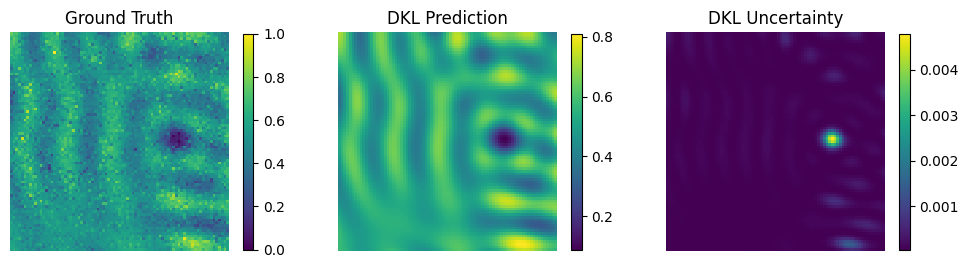

In [ ]:
mean, var = dklgp.predict(X, batch_size=len(X))
plot_dkl_result(y, mean, var)

And visualize the latent variables.

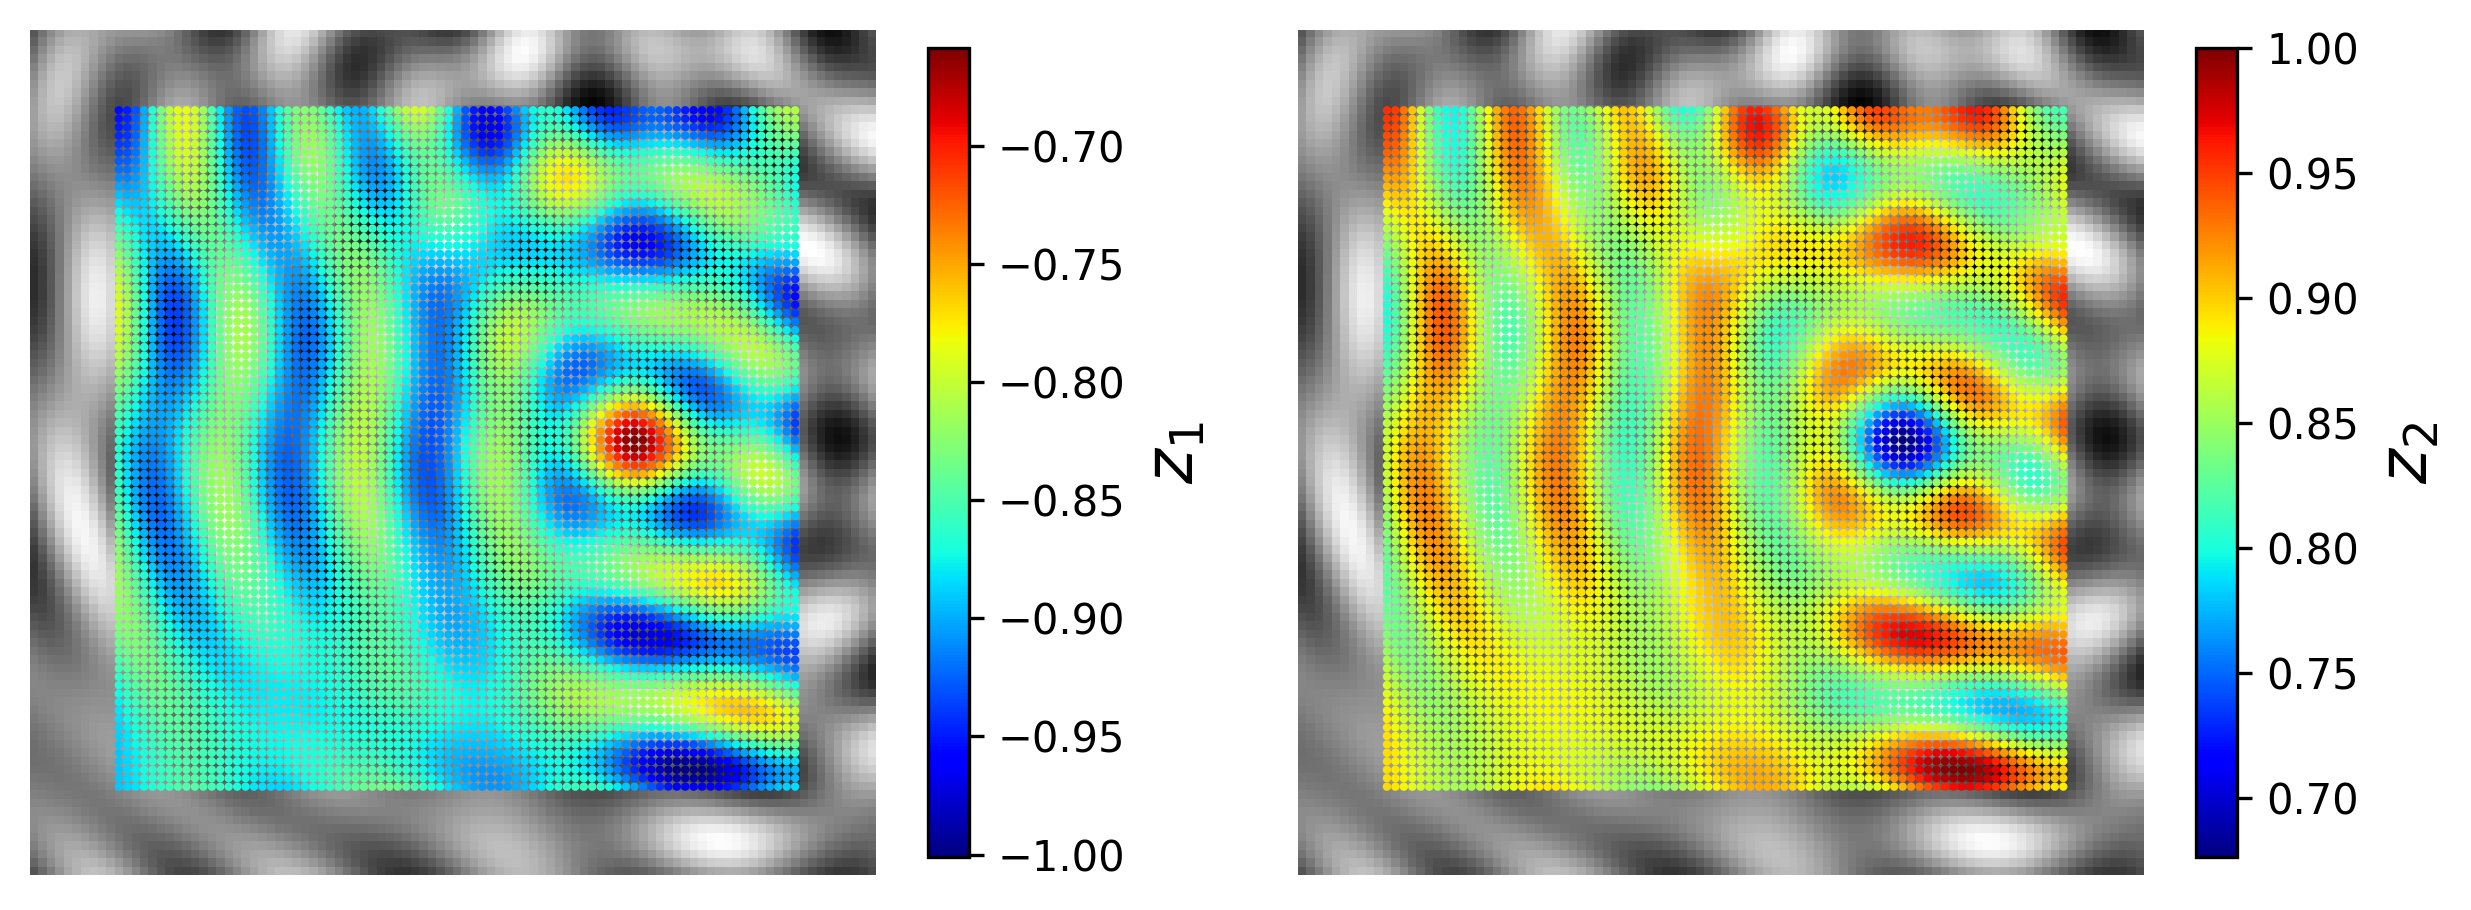

In [ ]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi = 300)
ax1.imshow(patch_image, origin = "lower", cmap = 'gray')
im1=ax1.scatter(indices_all[:,1], indices_all[:,0], s=1, c = embeded[:,0].reshape(pix, pix), cmap = 'jet')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar1.set_label("$z_1$", fontsize=16)

ax2.imshow(patch_image, origin = "lower", cmap = 'gray')
im2=ax2.scatter(indices_all[:,1], indices_all[:,0], s=1, c = embeded[:,1].reshape(pix, pix), cmap = 'jet')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar2.set_label("$z_2$", fontsize=16)

# **4. Active experiment**

Now, let's see how DKL will work for in the (simulated) automated experiment. We can select a single acquisition function (EI, MU, UCB), or explore all three. Also here we choose scalarizer 1.

In [ ]:
## Some globals

exploration_steps = 100 #50
num_cycles        = 100 #20 or 200

xi = 0.01  # balances exploration and explitation for EI and qEI
cm = 'viridis'
shrink = 0.7

# ts = 0.995  # (0.9995 for key 3) test data size: # Adjust ts to be as small as possible without running into error
# rs = 42   #random state determines initial train data, 42 because answer to everything

## DKL exploration



We can run exploration using a single acquisition function. Alternatively, we can explore all three and compare results.

In [ ]:
# Make a test size array
train_size = np.asarray([1, 50, 200, 500, 1000])
train_percent = train_size/len(X)
test_size = 1 - train_percent #test data size: # Adjust ts to be as small as possible without running into error

In [ ]:
rs = 20   #random state determines initial train data, 42 because answer to everything

for i in range (len(test_size)):
  ts = test_size[i]
  # determine acqusition funciton,
  acq = 3  # 0 uses EI, 1 explores max uncertainty point, 2 uses UCB

  rf = '/content/rf_train_size{}/'.format(train_size[i])   #root folder
  if not os.path.exists(rf):
    os.mkdir(rf)

  acq_funcs = ['EI', 'MU', 'UCB']   #list corresponds to Func sel_next_point.

  if acq == 3:             # when acq = 3, run all acq_funcs
    if not os.path.exists(rf + acq_funcs[0]):
      os.mkdir(rf + acq_funcs[0])
    if not os.path.exists(rf + acq_funcs[1]):
      os.mkdir(rf + acq_funcs[1])
    if not os.path.exists(rf + acq_funcs[2]):
      os.mkdir(rf + acq_funcs[2])
  elif acq < 3:
    if not os.path.exists(rf + acq_funcs[acq]):  # change root folder name when you change acquistion funciton
      os.mkdir(rf + acq_funcs[acq])

  save_explore =  "/explore_dkl_record/"
  y_targ = tar_amp   #training output;
  y_targ = (y_targ-y_targ.min())/(y_targ.max()-y_targ.min())
  y = y_targ.reshape(-1)

  # run DKL exploration with different acquisition functions
  if acq < 3:   # if user select an individual acquistion function
    acq_idx = acq
    dkl_explore(save_explore, num_cycles)

  elif acq == 3:  # if user selected to run all acquistion functions
    for i in range (3):
      acq_idx = i
      dkl_explore(save_explore, num_cycles)
    clear_output()

## Zip and download all results


In [ ]:
# !zip -r /content/Forensic_Toy_Data.zip /content/rf   # zip the root folder

# Use this code if you would like to download the analysis to your computer
# from google.colab import files
# files.download("/content/Forensic_EELS_NP1_20explore.zip")



# **5. Forensic analysis**

Import PyroVED for the VAE analysis

In [ ]:
%%capture
!pip install --upgrade git+https://github.com/ziatdinovmax/pyroved.git

In [ ]:
import os
import glob
import h5py
from copy import deepcopy as dc

from scipy import ndimage
from sklearn import decomposition

import pyroved as pv

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

import atomai as aoi
from atomai.utils import extract_patches_
from atomai import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Learning curve analysis

Load results of  **Live model** (the actual model that is being trained during the experiment), **Final model** (the model available in the end of experiment), and **Complete model** (trained on full data if it is available, i.e. via grid measurement)

In [ ]:
var = np.empty((len(test_size), 3, exploration_steps, 2))
measured_points = np.empty((len(test_size), 3, exploration_steps))

for ts_idx in range(len(test_size)):
  rf = "/content/rf_train_size{}/".format(train_size[ts_idx])

  for acq_idx in range (3):
    os.chdir (rf + acq_funcs[acq_idx] + '/explore_dkl_record')

    for step in range (exploration_steps):
      record_ = np.load("record{}.npz".format(step))
      var[ts_idx, acq_idx, step, 0] = record_["var"].mean()
      var[ts_idx, acq_idx, step, 1] = record_["var"].std()
      measured_points[ts_idx, acq_idx, step] = record_["measured_point"]

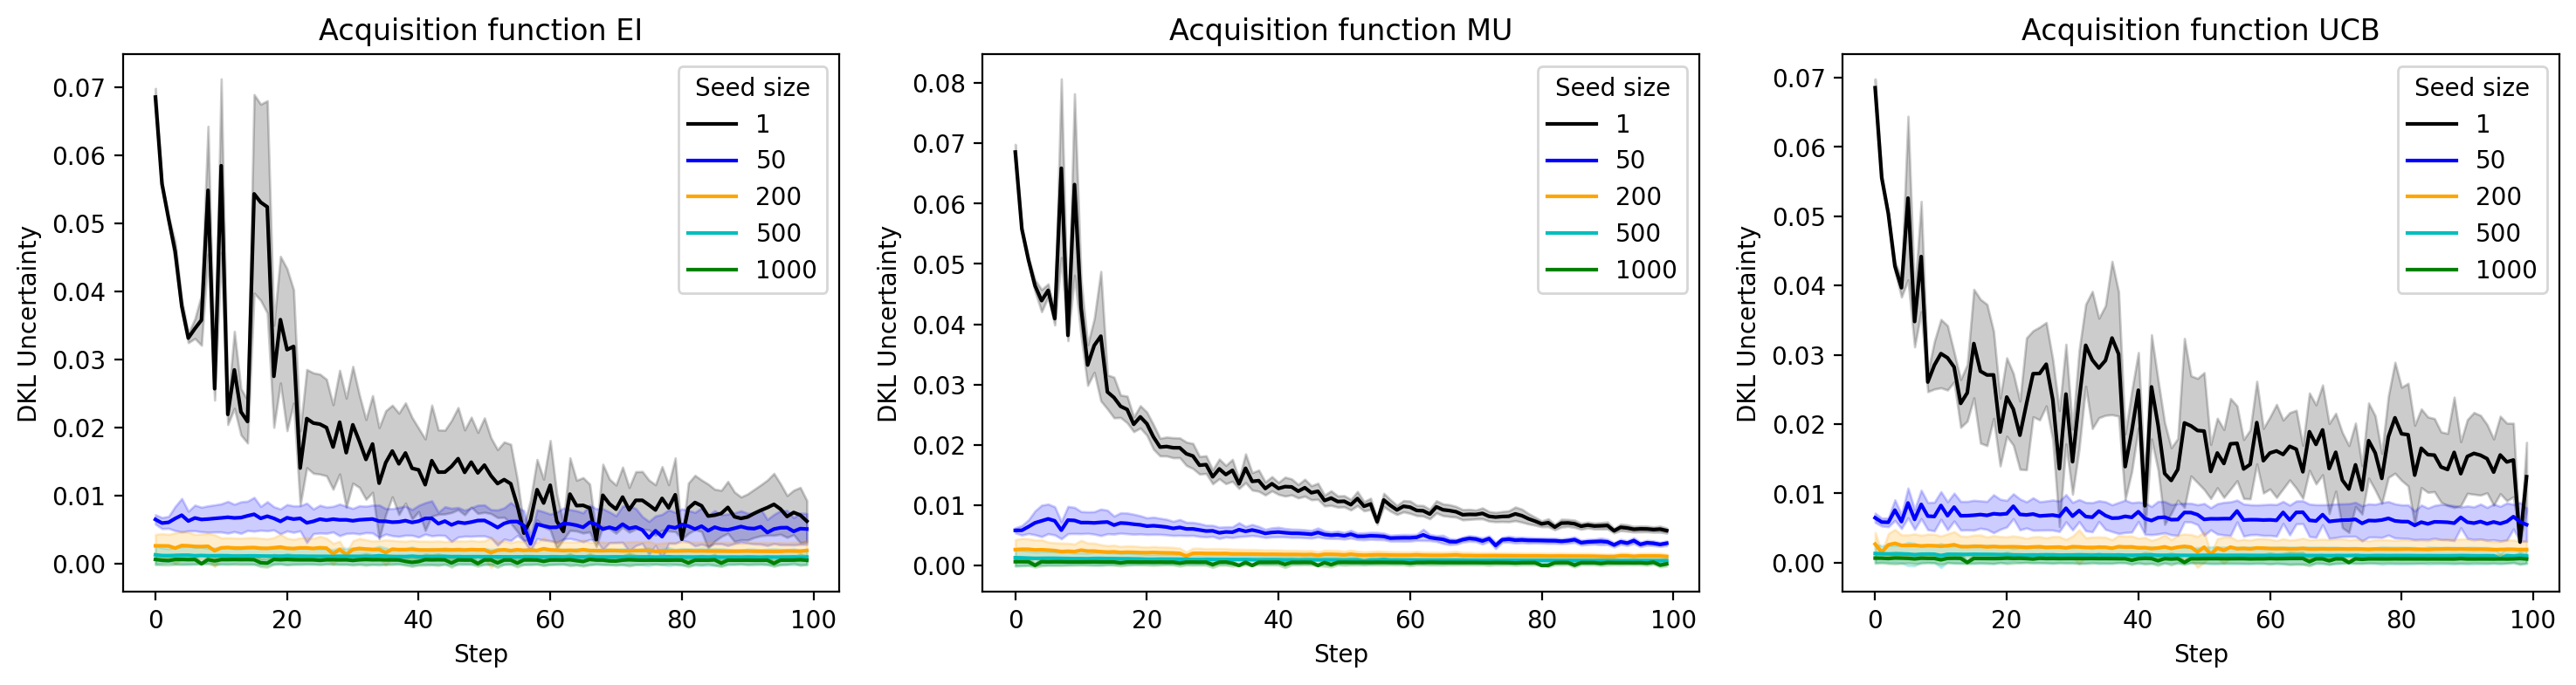

In [ ]:
s = np.arange(exploration_steps) #step

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 4), dpi = 200)

#Plot EI
ai = 0
ax1.set_title("Acquisition function EI")
tz = 0
ax1.plot(s, var[tz,ai,:,0], c= 'black', label = str(train_size[tz]))
ax1.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='black', alpha=0.2)

tz = 1
ax1.plot(s, var[tz,ai,:,0], c= 'blue', label = str(train_size[tz]))
ax1.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='blue', alpha=0.2)

tz = 2
ax1.plot(s, var[tz,ai,:,0], c= 'orange', label = str(train_size[tz]))
ax1.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='orange', alpha=0.2)

tz = 3
ax1.plot(s, var[tz,ai,:,0], c= 'c', label = str(train_size[tz]))
ax1.fill_between(s, var[tz, ai,:,0]-var[tz, ai,:,1], var[tz, ai,:,0]+var[tz, ai,:,1], color='c', alpha=0.2)

tz = 4
ax1.plot(s, var[tz,ai,:,0], c= 'g', label = str(train_size[tz]))
ax1.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='g', alpha=0.2)

ax1.set_ylabel("DKL Uncertainty")
ax1.set_xlabel('Step')
ax1.legend(title = "Seed size")

#Plot MU
ax2.set_title("Acquisition function MU")
ai = 1
tz = 0
ax2.plot(s, var[tz,ai,:,0], c= 'black', label = str(train_size[tz]))
ax2.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='black', alpha=0.2)

tz = 1
ax2.plot(s, var[tz,ai,:,0], c= 'blue', label = str(train_size[tz]))
ax2.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='blue', alpha=0.2)

tz = 2
ax2.plot(s, var[tz,ai,:,0], c= 'orange', label = str(train_size[tz]))
ax2.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='orange', alpha=0.2)

tz = 3
ax2.plot(s, var[tz,ai,:,0], c= 'c', label = str(train_size[tz]))
ax2.fill_between(s, var[tz, ai,:,0]-var[tz, ai,:,1], var[tz, ai,:,0]+var[tz, ai,:,1], color='c', alpha=0.2)

tz = 4
ax2.plot(s, var[tz,ai,:,0], c= 'g', label = str(train_size[tz]))
ax2.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='g', alpha=0.2)

ax2.set_ylabel("DKL Uncertainty")
ax2.set_xlabel('Step')
ax2.legend(title = "Seed size")

#Plot UCB
ax3.set_title("Acquisition function UCB")
ai = 2
tz = 0
ax3.plot(s, var[tz,ai,:,0], c='black', label = str(train_size[tz]))
ax3.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='black', alpha=0.2)

tz = 1
ax3.plot(s, var[tz,ai,:,0], c= 'blue', label = str(train_size[tz]))
ax3.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='blue', alpha=0.2)

tz = 2
ax3.plot(s, var[tz,ai,:,0], c= 'orange', label = str(train_size[tz]))
ax3.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='orange', alpha=0.2)

tz = 3
ax3.plot(s, var[tz,ai,:,0], c= 'c', label = str(train_size[tz]))
ax3.fill_between(s, var[tz, ai,:,0]-var[tz, ai,:,1], var[tz, ai,:,0]+var[tz, ai,:,1], color='c', alpha=0.2)

tz = 4
ax3.plot(s, var[tz,ai,:,0], c= 'g', label = str(train_size[tz]))
ax3.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='g', alpha=0.2)

ax3.set_ylabel("DKL Uncertainty")
ax3.set_xlabel('Step')
ax3.legend(title = "Seed size")

plt.show()

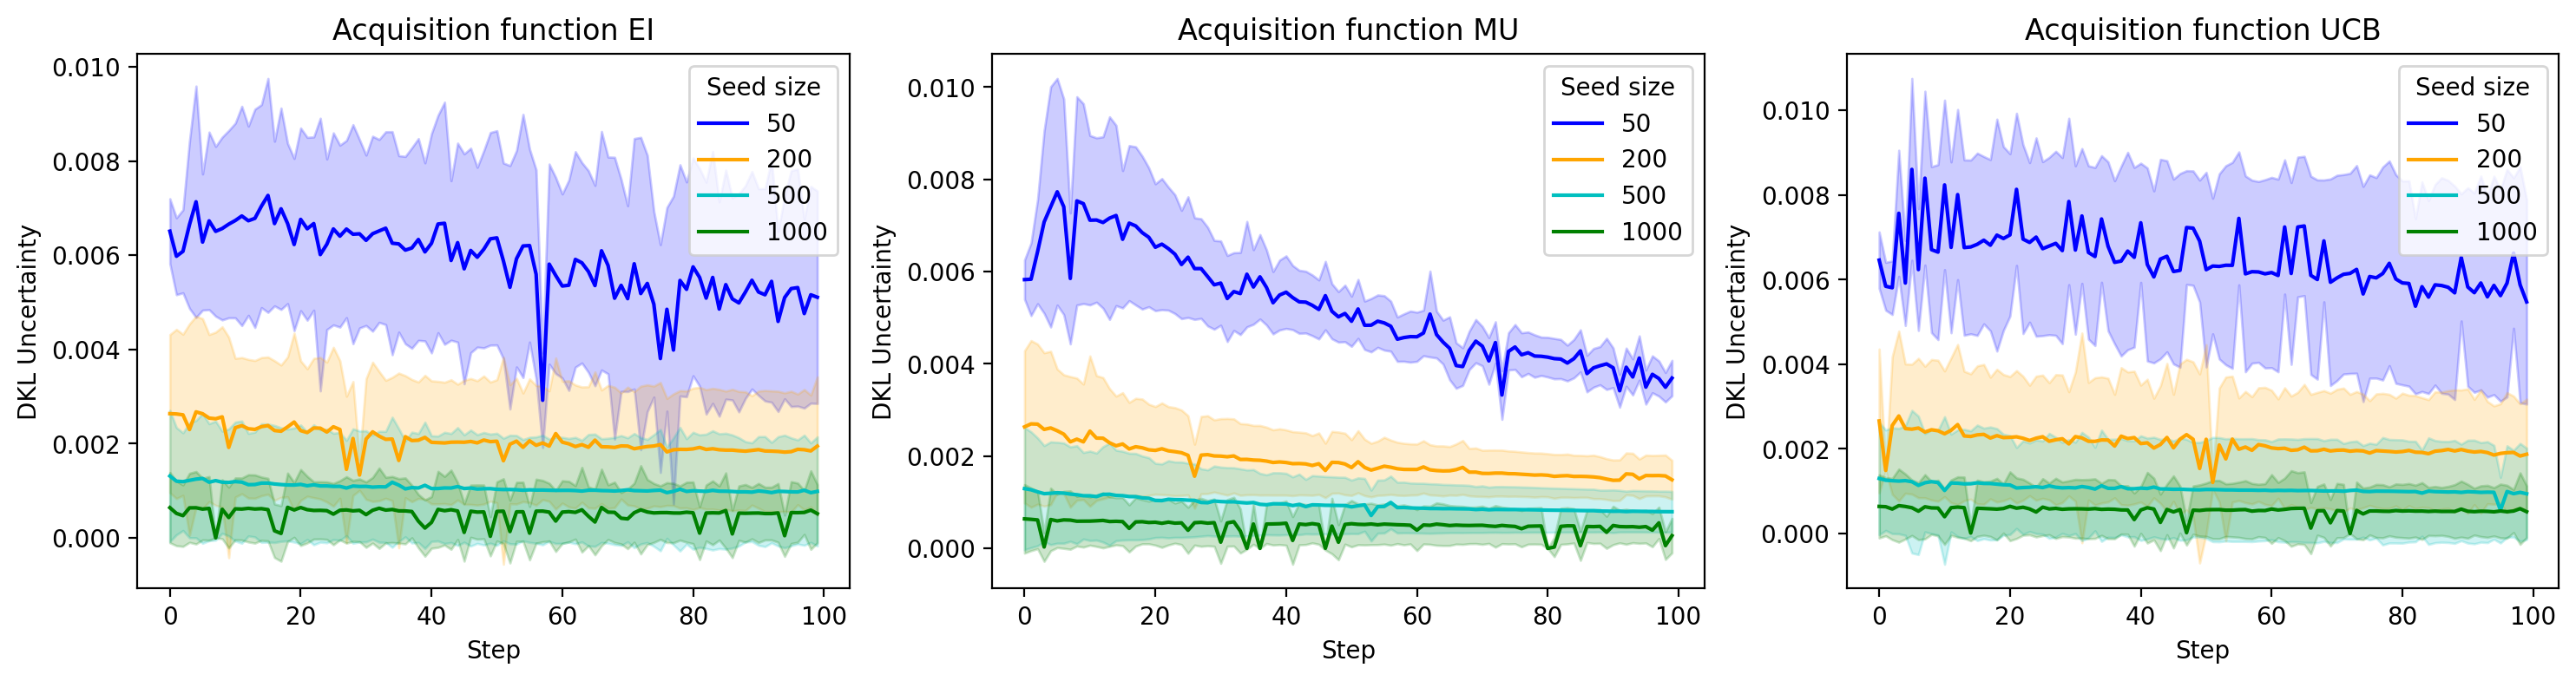

In [ ]:
s = np.arange(exploration_steps) #step

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 4), dpi = 200)

#Plot EI
ai = 0
ax1.set_title("Acquisition function EI")
# tz = 0
# ax1.plot(s, var[tz,ai,:,0], c= 'black', label = str(train_size[tz]))
# ax1.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='black', alpha=0.2)

tz = 1
ax1.plot(s, var[tz,ai,:,0], c= 'blue', label = str(train_size[tz]))
ax1.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='blue', alpha=0.2)

tz = 2
ax1.plot(s, var[tz,ai,:,0], c= 'orange', label = str(train_size[tz]))
ax1.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='orange', alpha=0.2)

tz = 3
ax1.plot(s, var[tz,ai,:,0], c= 'c', label = str(train_size[tz]))
ax1.fill_between(s, var[tz, ai,:,0]-var[tz, ai,:,1], var[tz, ai,:,0]+var[tz, ai,:,1], color='c', alpha=0.2)

tz = 4
ax1.plot(s, var[tz,ai,:,0], c= 'g', label = str(train_size[tz]))
ax1.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='g', alpha=0.2)

ax1.set_ylabel("DKL Uncertainty")
ax1.set_xlabel('Step')
ax1.legend(title = "Seed size")

#Plot MU
ax2.set_title("Acquisition function MU")
ai = 1
tz = 0
# ax2.plot(s, var[tz,ai,:,0], c= 'black', label = str(train_size[tz]))
# ax2.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='black', alpha=0.2)

tz = 1
ax2.plot(s, var[tz,ai,:,0], c= 'blue', label = str(train_size[tz]))
ax2.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='blue', alpha=0.2)

tz = 2
ax2.plot(s, var[tz,ai,:,0], c= 'orange', label = str(train_size[tz]))
ax2.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='orange', alpha=0.2)

tz = 3
ax2.plot(s, var[tz,ai,:,0], c= 'c', label = str(train_size[tz]))
ax2.fill_between(s, var[tz, ai,:,0]-var[tz, ai,:,1], var[tz, ai,:,0]+var[tz, ai,:,1], color='c', alpha=0.2)

tz = 4
ax2.plot(s, var[tz,ai,:,0], c= 'g', label = str(train_size[tz]))
ax2.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='g', alpha=0.2)

ax2.set_ylabel("DKL Uncertainty")
ax2.set_xlabel('Step')
ax2.legend(title = "Seed size")

#Plot UCB
ax3.set_title("Acquisition function UCB")
ai = 2
tz = 0
# ax3.plot(s, var[tz,ai,:,0], c='black', label = str(train_size[tz]))
# ax3.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='black', alpha=0.2)

tz = 1
ax3.plot(s, var[tz,ai,:,0], c= 'blue', label = str(train_size[tz]))
ax3.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz, ai,:,0]+var[tz,ai,:,1], color='blue', alpha=0.2)

tz = 2
ax3.plot(s, var[tz,ai,:,0], c= 'orange', label = str(train_size[tz]))
ax3.fill_between(s, var[tz, ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='orange', alpha=0.2)

tz = 3
ax3.plot(s, var[tz,ai,:,0], c= 'c', label = str(train_size[tz]))
ax3.fill_between(s, var[tz, ai,:,0]-var[tz, ai,:,1], var[tz, ai,:,0]+var[tz, ai,:,1], color='c', alpha=0.2)

tz = 4
ax3.plot(s, var[tz,ai,:,0], c= 'g', label = str(train_size[tz]))
ax3.fill_between(s, var[tz,ai,:,0]-var[tz,ai,:,1], var[tz,ai,:,0]+var[tz,ai,:,1], color='g', alpha=0.2)

ax3.set_ylabel("DKL Uncertainty")
ax3.set_xlabel('Step')
ax3.legend(title = "Seed size")

plt.show()

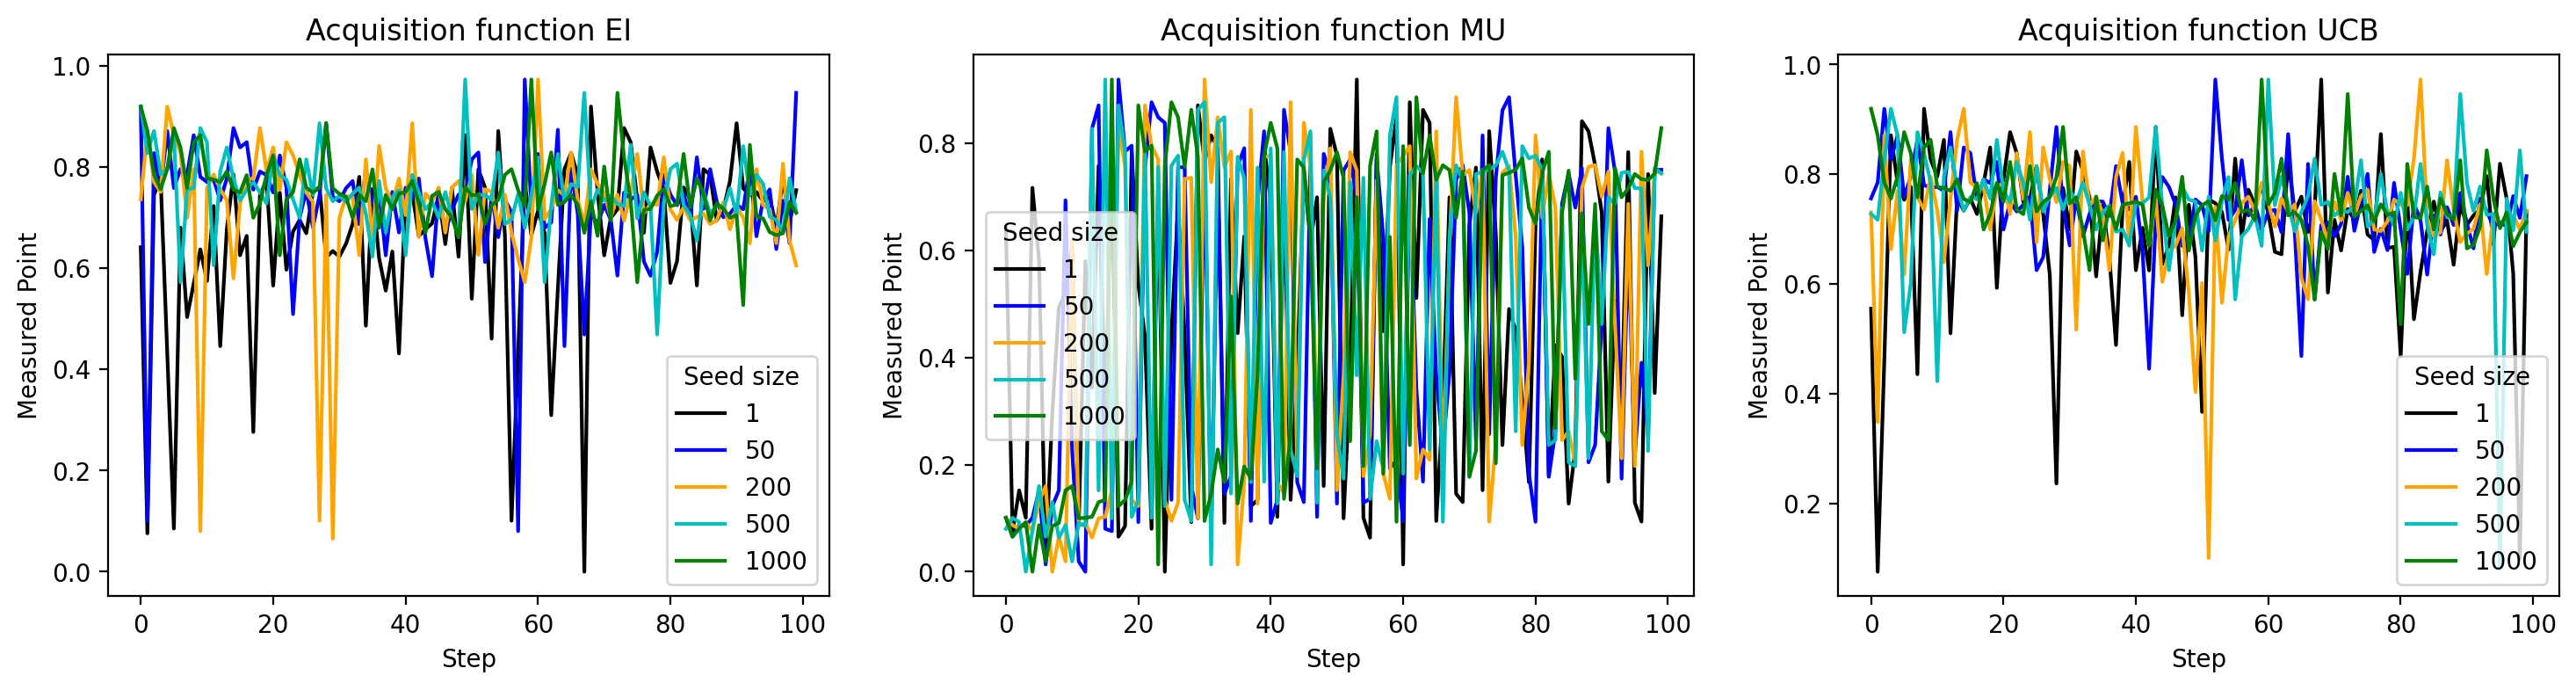

In [ ]:
s = np.arange(exploration_steps) #step

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 4), dpi = 200)

#Plot EI
ai = 0
ax1.set_title("Acquisition function EI")
tz = 0
ax1.plot(s, measured_points[tz, ai,:], c= 'black', label = str(train_size[tz]))
tz = 1
ax1.plot(s, measured_points[tz, ai,:], c= 'blue', label = str(train_size[tz]))
tz = 2
ax1.plot(s, measured_points[tz, ai,:], c= 'orange', label = str(train_size[tz]))
tz = 3
ax1.plot(s, measured_points[tz, ai,:], c= 'c', label = str(train_size[tz]))
tz = 4
ax1.plot(s, measured_points[tz, ai,:], c= 'g', label = str(train_size[tz]))

ax1.set_ylabel("Measured Point")
ax1.set_xlabel('Step')
ax1.legend(title = "Seed size")

#Plot MU
ax2.set_title("Acquisition function MU")
ai = 1
tz = 0
ax2.plot(s, measured_points[tz, ai,:], c= 'black', label = str(train_size[tz]))
tz = 1
ax2.plot(s, measured_points[tz, ai,:], c= 'blue', label = str(train_size[tz]))
tz = 2
ax2.plot(s, measured_points[tz, ai,:], c= 'orange', label = str(train_size[tz]))
tz = 3
ax2.plot(s, measured_points[tz, ai,:], c= 'c', label = str(train_size[tz]))
tz = 4
ax2.plot(s, measured_points[tz, ai,:], c= 'g', label = str(train_size[tz]))

ax2.set_ylabel("Measured Point")
ax2.set_xlabel('Step')
ax2.legend(title = "Seed size")

#Plot UCB
ax3.set_title("Acquisition function UCB")
ai = 2
tz = 0
ax3.plot(s, measured_points[tz, ai,:], c='black', label = str(train_size[tz]))
tz = 1
ax3.plot(s, measured_points[tz, ai,:], c= 'blue', label = str(train_size[tz]))
tz = 2
ax3.plot(s, measured_points[tz, ai,:], c= 'orange', label = str(train_size[tz]))
tz = 3
ax3.plot(s, measured_points[tz, ai,:], c= 'c', label = str(train_size[tz]))
tz = 4
ax3.plot(s, measured_points[tz, ai,:], c= 'g', label = str(train_size[tz]))

ax3.set_ylabel("Measured Point")
ax3.set_xlabel('Step')
ax3.legend(title = "Seed size")

plt.show()

In [ ]:
traj_EI = np.zeros((len(test_size), exploration_steps, 2))
traj_MU = np.zeros((len(test_size), exploration_steps, 2))
traj_UCB = np.zeros((len(test_size), exploration_steps, 2))

for ts_idx in range(len(test_size)):
  rf = "/content/rf_train_size{}/".format(train_size[ts_idx])
  for i in range (exploration_steps):
    os.chdir (rf + acq_funcs[0] + save_explore)
    rec = np.load("record{}.npz".format(i))
    nextpoint = rec ['next_point']
    traj_EI [ts_idx, i, ] = nextpoint

    try:
      os.chdir (rf + acq_funcs[1] + save_explore)
      rec = np.load("record{}.npz".format(i))
      nextpoint = rec ['next_point']
      traj_MU [ts_idx, i, ] = nextpoint
    except FileNotFoundError:
      pass

    os.chdir (rf + acq_funcs[2] + save_explore)
    rec = np.load("record{}.npz".format(i))
    nextpoint = rec ['next_point']
    traj_UCB [ts_idx, i, ] = nextpoint

(-0.5, 99.5, -0.5, 99.5)

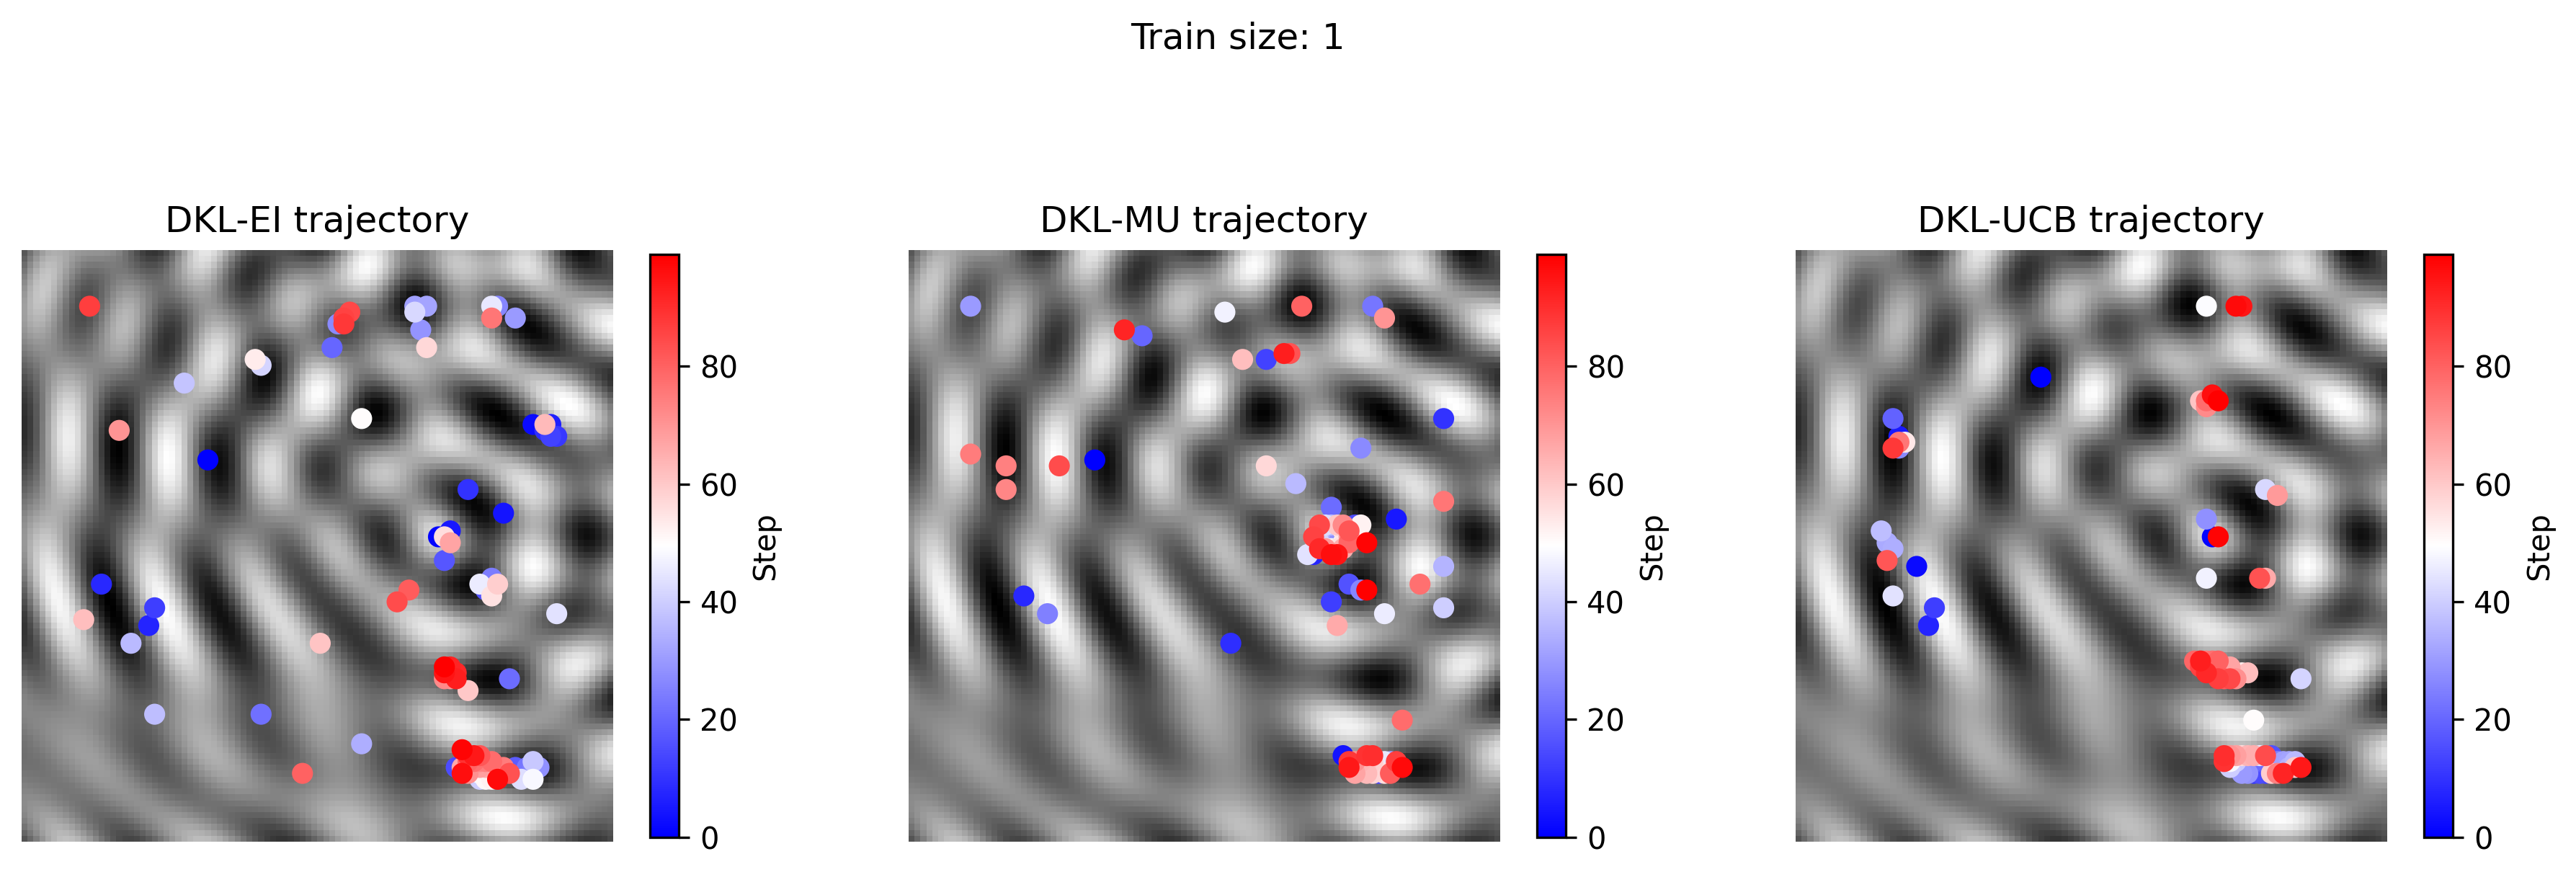

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)

cm = 'gray'
shrink = 0.7
ts_idx = 0
fig.suptitle("Train size: {}".format(train_size[ts_idx]))

ax1.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im1 = ax1.scatter(traj_EI[ts_idx, :,1], traj_EI[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im1, ax=ax1, shrink = shrink, label = "Step")
ax1.set_title("DKL-EI trajectory")
ax1.axis('off')

ax2.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im2 = ax2.scatter(traj_MU[ts_idx,:,1], traj_MU[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im2, ax=ax2, shrink = shrink, label = "Step")
ax2.set_title("DKL-MU trajectory")
ax2.axis('off')

ax3.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im3 = ax3.scatter(traj_UCB[ts_idx,:,1], traj_UCB[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im3, ax=ax3, shrink = shrink, label = "Step")
ax3.set_title("DKL-UCB trajectory")
ax3.axis('off')

(-0.5, 99.5, -0.5, 99.5)

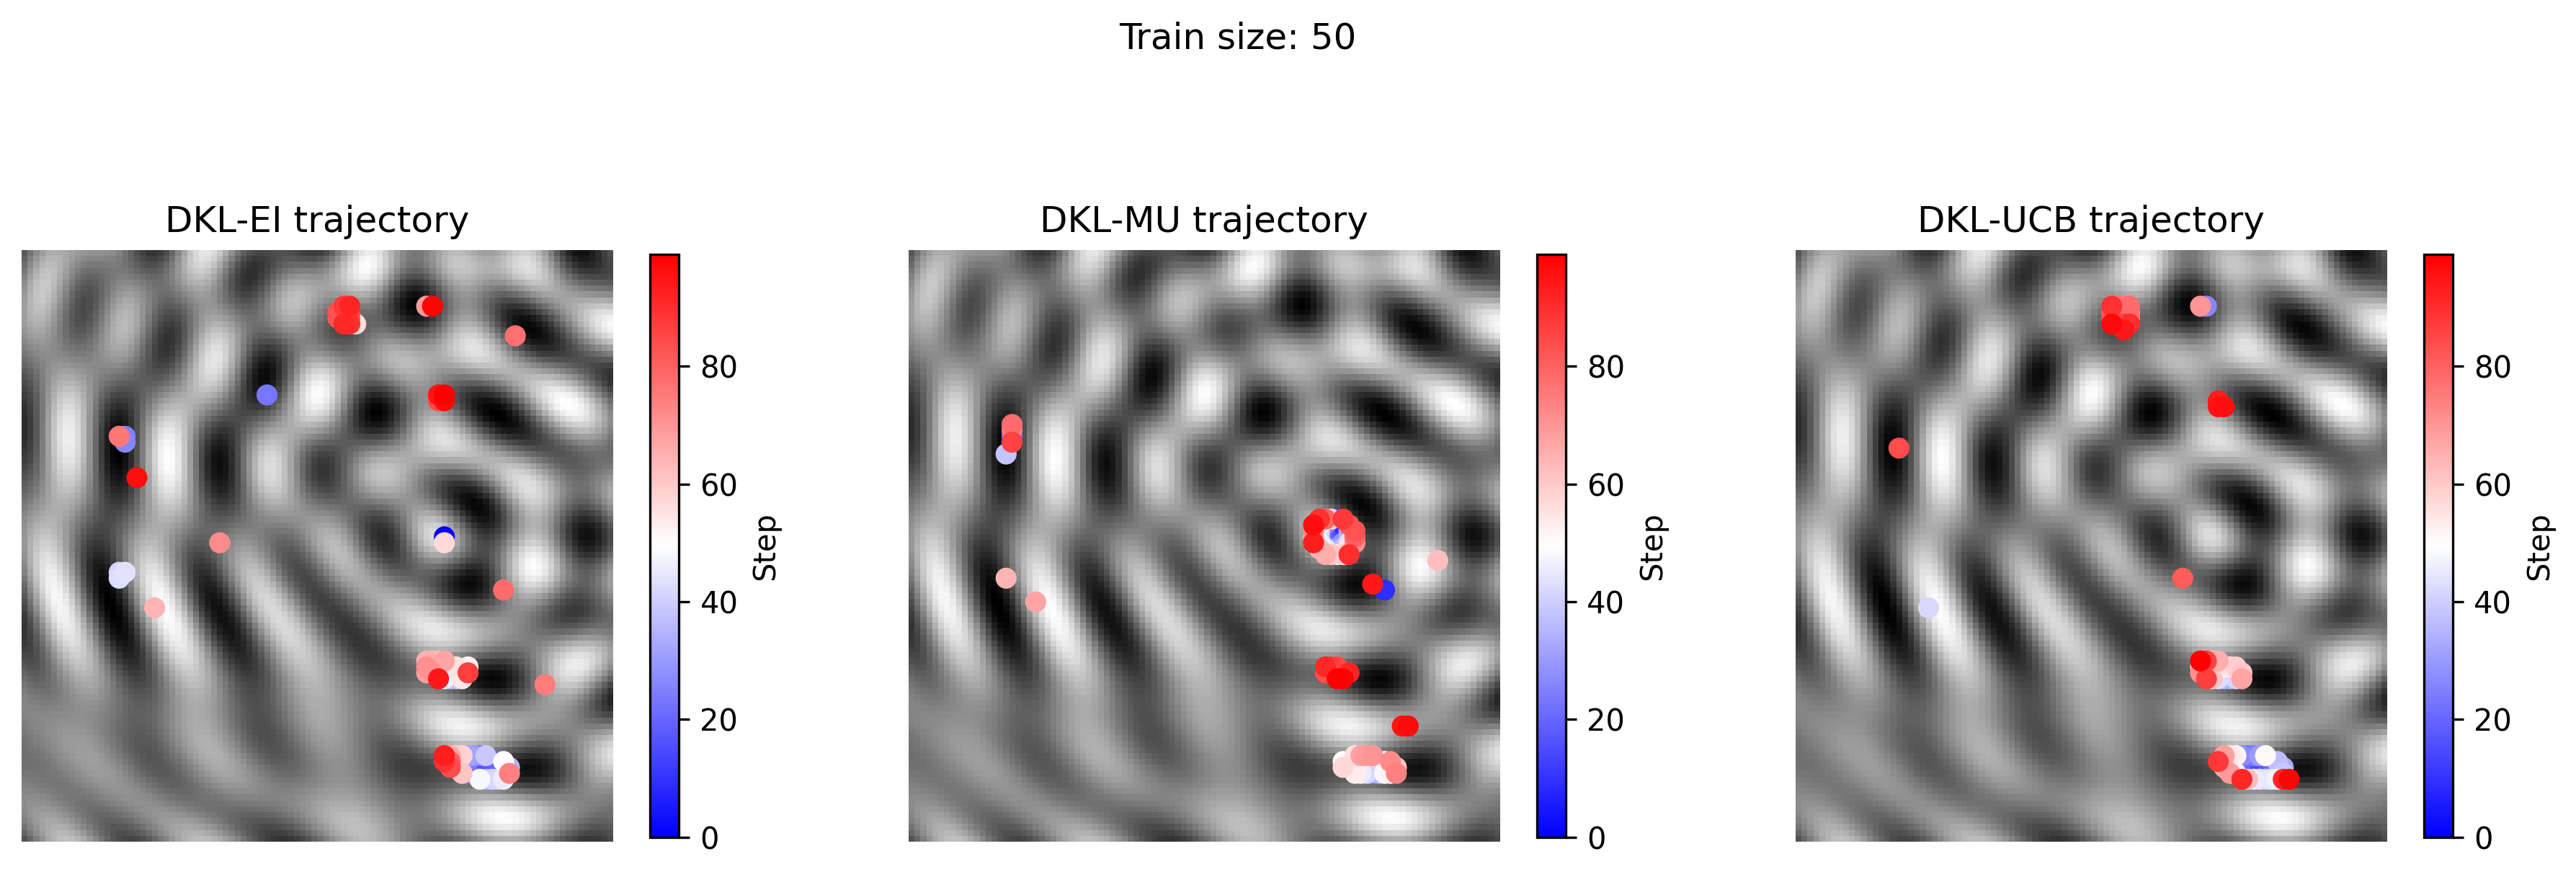

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)

cm = 'gray'
shrink = 0.7
ts_idx = 1
fig.suptitle("Train size: {}".format(train_size[ts_idx]))

ax1.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im1 = ax1.scatter(traj_EI[ts_idx, :,1], traj_EI[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im1, ax=ax1, shrink = shrink, label = "Step")
ax1.set_title("DKL-EI trajectory")
ax1.axis('off')

ax2.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im2 = ax2.scatter(traj_MU[ts_idx,:,1], traj_MU[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im2, ax=ax2, shrink = shrink, label = "Step")
ax2.set_title("DKL-MU trajectory")
ax2.axis('off')

ax3.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im3 = ax3.scatter(traj_UCB[ts_idx,:,1], traj_UCB[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im3, ax=ax3, shrink = shrink, label = "Step")
ax3.set_title("DKL-UCB trajectory")
ax3.axis('off')

(-0.5, 99.5, -0.5, 99.5)

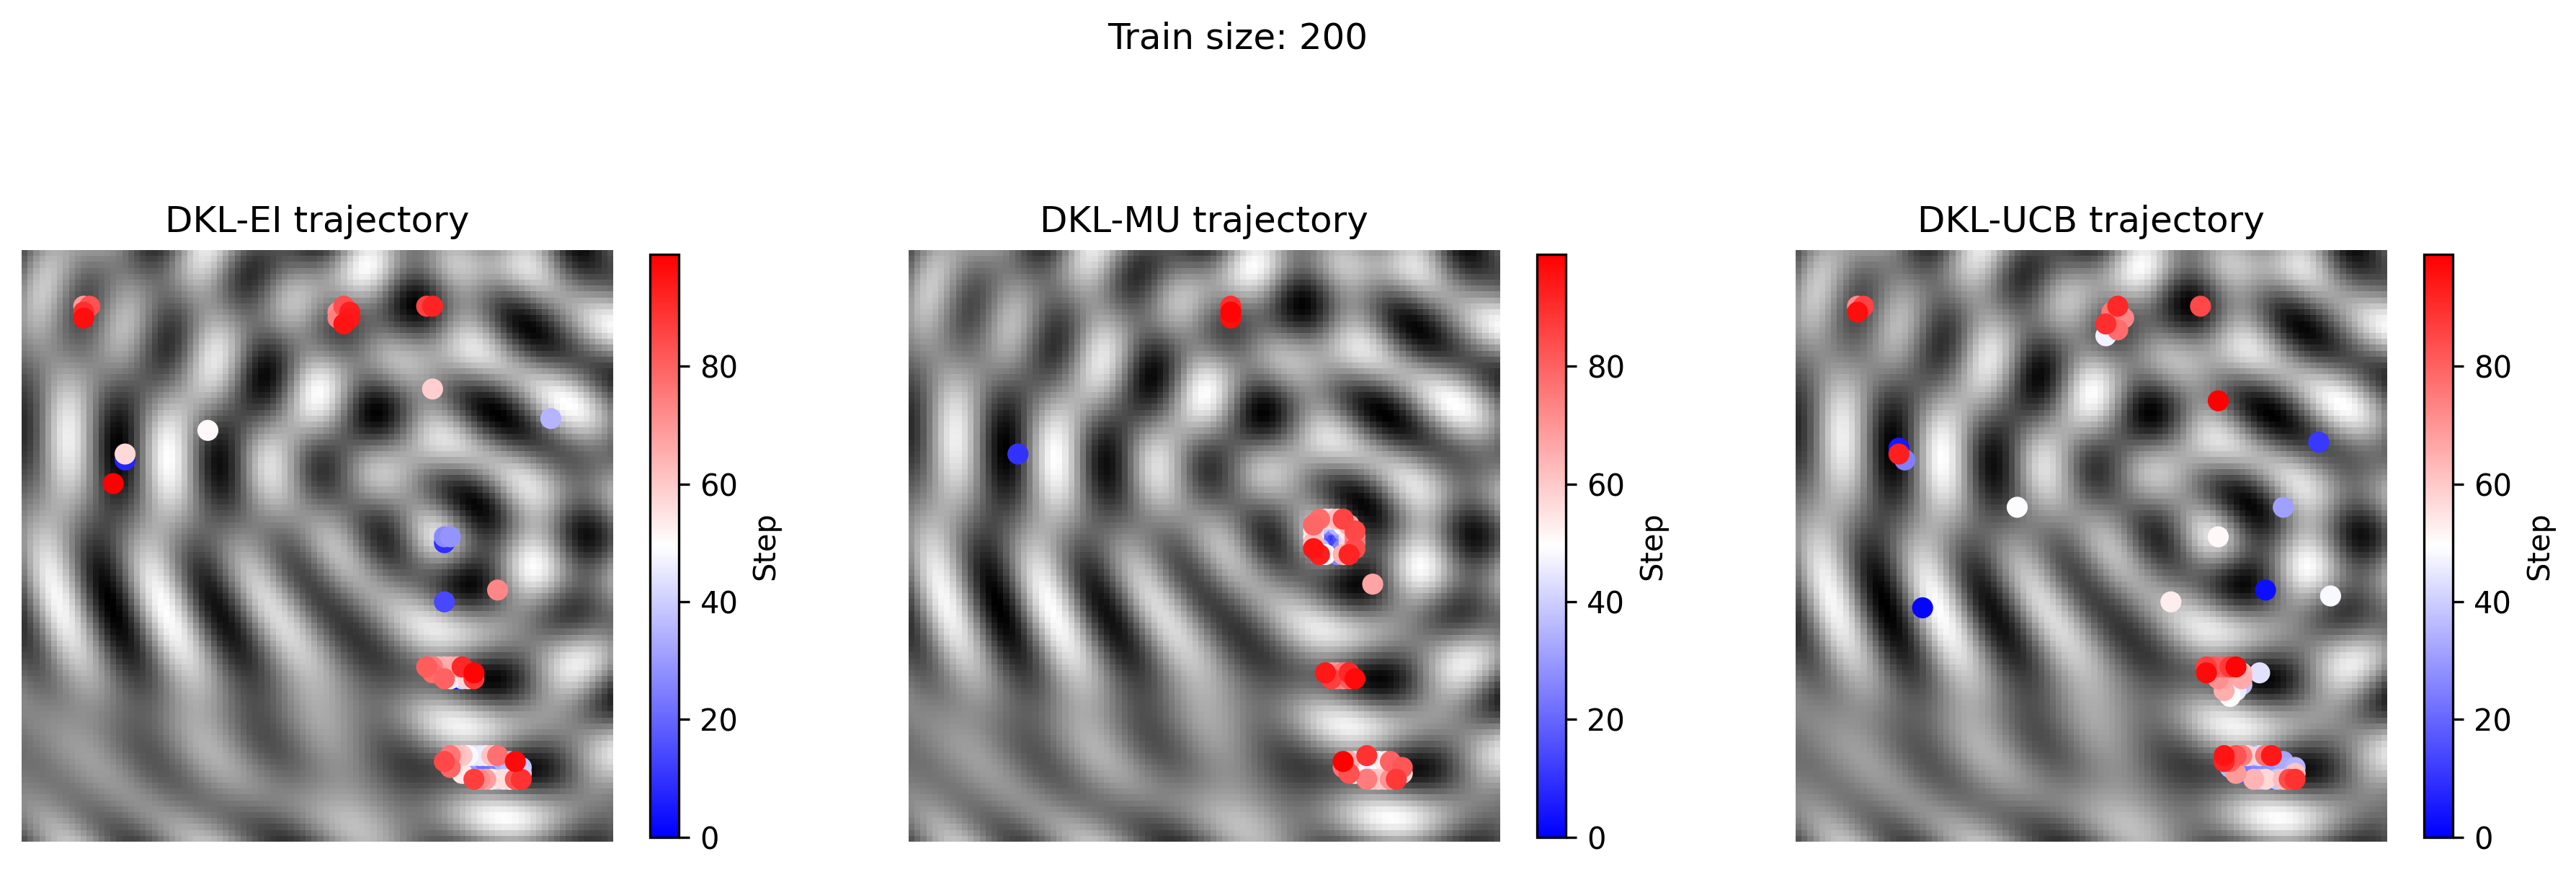

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)

cm = 'gray'
shrink = 0.7
ts_idx = 2
fig.suptitle("Train size: {}".format(train_size[ts_idx]))

ax1.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im1 = ax1.scatter(traj_EI[ts_idx, :,1], traj_EI[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im1, ax=ax1, shrink = shrink, label = "Step")
ax1.set_title("DKL-EI trajectory")
ax1.axis('off')

ax2.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im2 = ax2.scatter(traj_MU[ts_idx,:,1], traj_MU[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im2, ax=ax2, shrink = shrink, label = "Step")
ax2.set_title("DKL-MU trajectory")
ax2.axis('off')

ax3.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im3 = ax3.scatter(traj_UCB[ts_idx,:,1], traj_UCB[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im3, ax=ax3, shrink = shrink, label = "Step")
ax3.set_title("DKL-UCB trajectory")
ax3.axis('off')

(-0.5, 99.5, -0.5, 99.5)

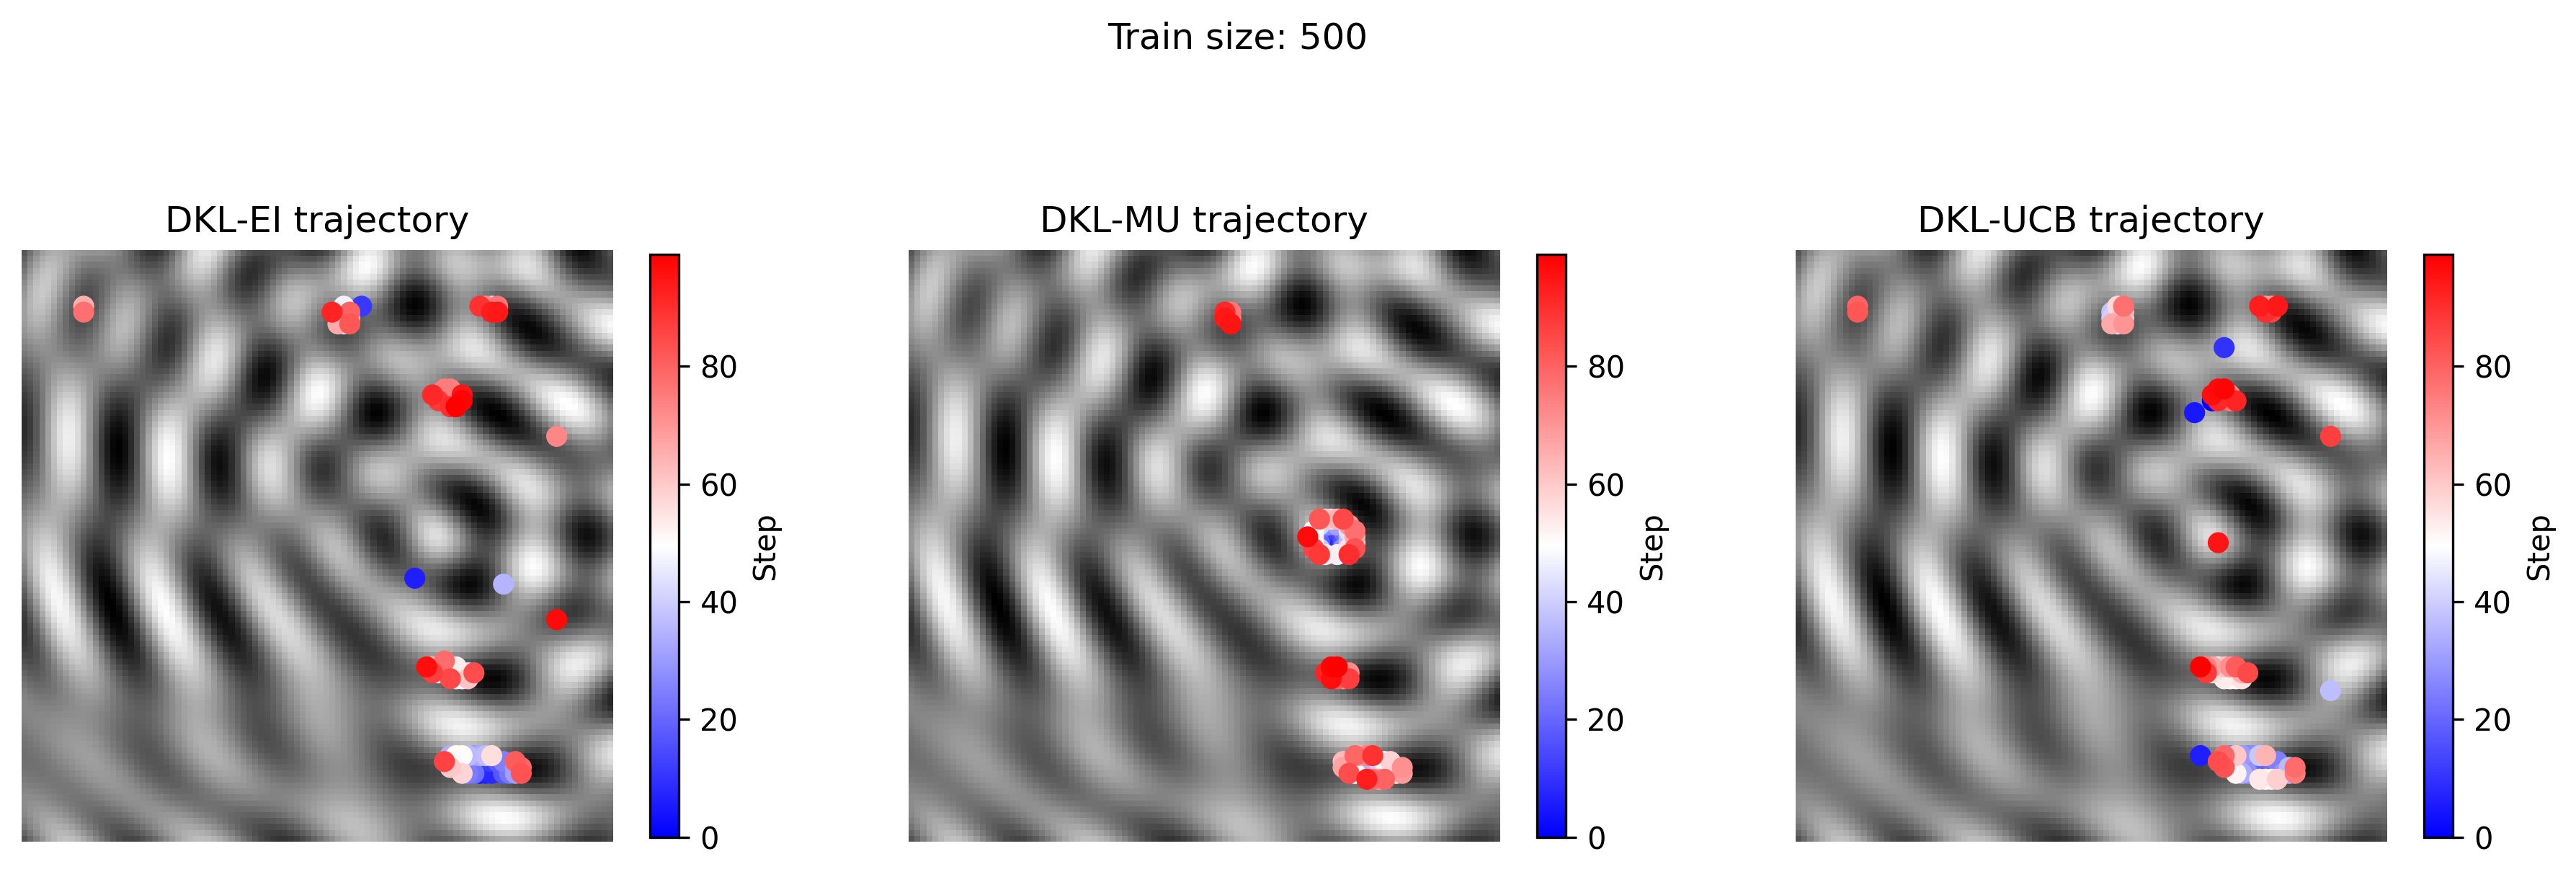

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)

cm = 'gray'
shrink = 0.7
ts_idx = 3
fig.suptitle("Train size: {}".format(train_size[ts_idx]))

ax1.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im1 = ax1.scatter(traj_EI[ts_idx, :,1], traj_EI[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im1, ax=ax1, shrink = shrink, label = "Step")
ax1.set_title("DKL-EI trajectory")
ax1.axis('off')

ax2.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im2 = ax2.scatter(traj_MU[ts_idx,:,1], traj_MU[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im2, ax=ax2, shrink = shrink, label = "Step")
ax2.set_title("DKL-MU trajectory")
ax2.axis('off')

ax3.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im3 = ax3.scatter(traj_UCB[ts_idx,:,1], traj_UCB[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im3, ax=ax3, shrink = shrink, label = "Step")
ax3.set_title("DKL-UCB trajectory")
ax3.axis('off')

(-0.5, 99.5, -0.5, 99.5)

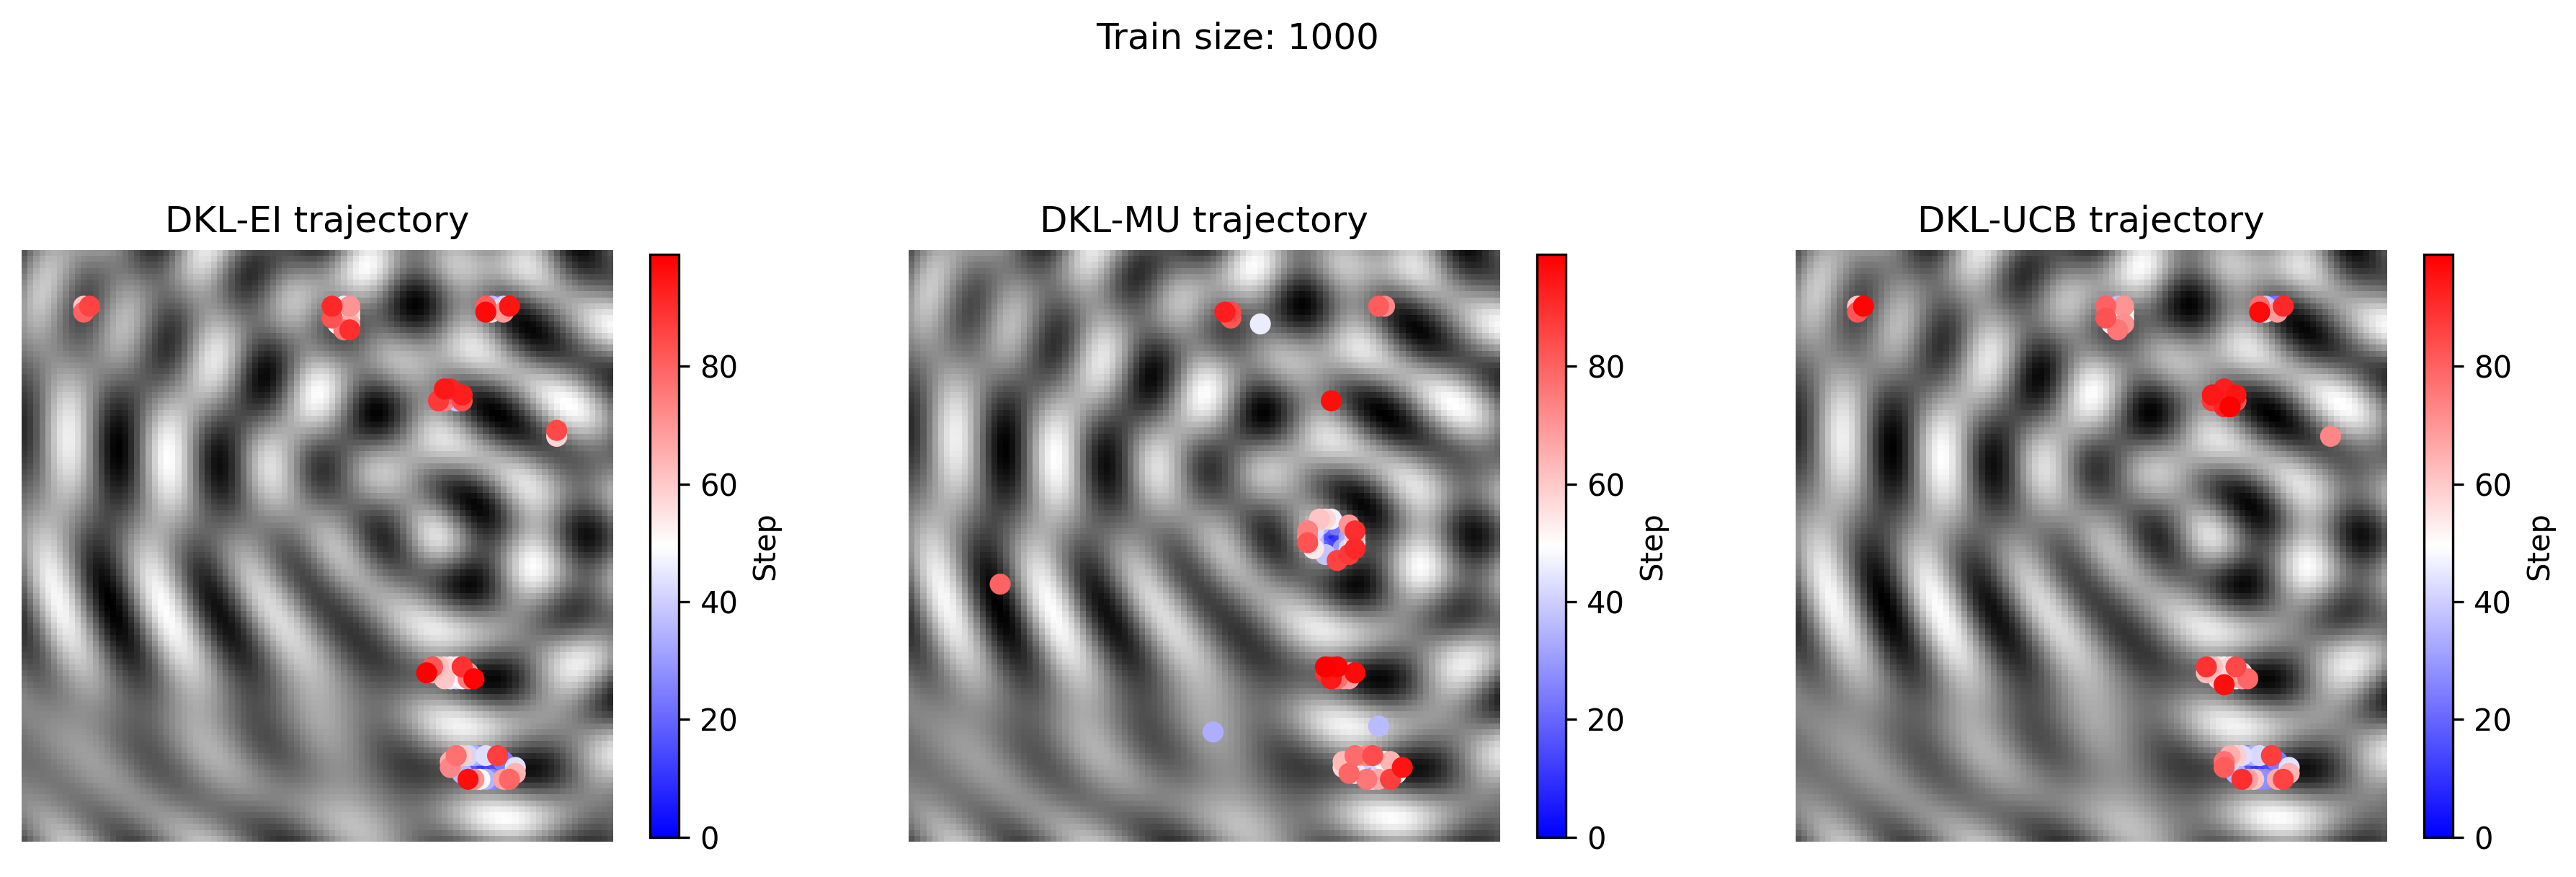

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi = 300)

cm = 'gray'
shrink = 0.7
ts_idx = 4
fig.suptitle("Train size: {}".format(train_size[ts_idx]))

ax1.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im1 = ax1.scatter(traj_EI[ts_idx, :,1], traj_EI[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im1, ax=ax1, shrink = shrink, label = "Step")
ax1.set_title("DKL-EI trajectory")
ax1.axis('off')

ax2.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im2 = ax2.scatter(traj_MU[ts_idx,:,1], traj_MU[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im2, ax=ax2, shrink = shrink, label = "Step")
ax2.set_title("DKL-MU trajectory")
ax2.axis('off')

ax3.imshow(full_img, interpolation='nearest', origin = "lower", cmap=cm)
im3 = ax3.scatter(traj_UCB[ts_idx,:,1], traj_UCB[ts_idx,:,0], c = np.arange(exploration_steps), cmap = 'bwr')
fig.colorbar(im3, ax=ax3, shrink = shrink, label = "Step")
ax3.set_title("DKL-UCB trajectory")
ax3.axis('off')